# Data Analytics in Supply Chain

To support the 2020 MSOM Data Driven Research Challenge, JD.com, China’s largest retailer,
offers transaction level data to MSOM members for conducting data-driven research. This article
describes the transactional data associated with over 2.5 million customers (anonymized) and
31,868 SKUs over the month of March in 2018

My literature review indicated that there was a gap between the analytics
techniques that were prescribed by academia and what was practised in the real world. To address this
gap, various forecasting techniques and strategies were applied to the supply chain data of a Chinese Ecommerce company, JD.com.
- Initially, the ease of implementation and accuracy of three forecasting models were compared, namely the Holt-Winters exponential smoothing model, a seasonal autoregressive integrated moving average (SARIMA) model, and Facebook’s Prohet model. HoltWinters’ exponential smoothing model achieved the highest forecast accuracy and was the simplest model to implement. 
- Next, several aggregation strategies were tested to examine their impact on demand forecast accuracy. The demand was aggregated by customer segment, product type, and location, and the demand was forecasted for the various groups. The aggregation was primarily done by manually segregating the groups according to a criteria; however, a K-Means clustering algorithm was also used to cluster products and customers. Forecast accuracy was improved by aggregating products based on their price and their descriptive features. Forecasting demand by customer segment or by location did not lead to any increase in forecast accuracy. 
- A strong correlation was identified between orders and discounts, and discounts were suggested to be the strongest predictor of demand in the available dataset; however causality should be established through controlled experiments. 

Some recommendations were included in my thesis (that aren't included in the analysis notebooks). To improve forecast accuracy in JD.com, the use of HoltWinters’ exponential smoothing model is recommended, owing to its simplicity and accuracy; the use of judgemental adjustments to forecasts in certain situations is recommended; and the aggregation techniques that improved forecast accuracy, or improved forecast granularity in this analysis are recommended for use in JD.com. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import seaborn as sns

import os
from IPython.display import display, HTML, Image, Latex
import time
import random
import math
from pylab import rcParams

import sklearn
import sklearn.linear_model
import statsmodels.api as sm
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm_notebook, tqdm

import fbprophet
from fbprophet import Prophet

from calendar import Calendar
import datetime

from venn import venn

from scipy import stats

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [3]:
orders = pd.read_csv('../Data/JD_order_data.csv')
single_orders = pd.read_csv('../Data/JD_single_orders.csv').drop(columns='Unnamed: 0',axis=1)

# Data Prep

In [4]:
def prepare_for_plotting(df):
    df = pd.DataFrame(df['order_time'])

    # change the string values to datetime and set it as the index
    df['order_time'] = pd.to_datetime(df['order_time'])
    df.set_index('order_time', inplace=True)

    # floor it to the hour 
    df.index = df.index.floor('H')

    # value counts gets all of the orders that happened that hour
    df = df.index.value_counts().sort_index()
    
    # add a zero value for any hour without data
    days_hours_march = [datetime.datetime(2018, 3, day, hour, 0, 0) for day in range(1, 32) for hour in range(24)]     
    zeros = pd.Series(data = 0, index = [x for x in days_hours_march if not x in df])
    df = df.append(zeros)

    df.sort_index(inplace=True)

    df = pd.DataFrame(df)
    df.rename(columns = {0:'orders'}, inplace = True)
    return df



In [5]:
prepare_for_plotting(single_orders)

orders
2018-03-01 00:00:00    2683
2018-03-01 01:00:00    1748
2018-03-01 02:00:00     421
2018-03-01 03:00:00     222
2018-03-01 04:00:00     159
...                     ...
2018-03-31 19:00:00    1015
2018-03-31 20:00:00    1231
2018-03-31 21:00:00    1463
2018-03-31 22:00:00    1679
2018-03-31 23:00:00    1201

[744 rows x 1 columns]

In [6]:
prepare_for_plotting(single_orders).describe()

orders
count   744.000000
mean    899.401882
std     640.383762
min      22.000000
25%     303.500000
50%     909.000000
75%    1313.000000
max    3666.000000

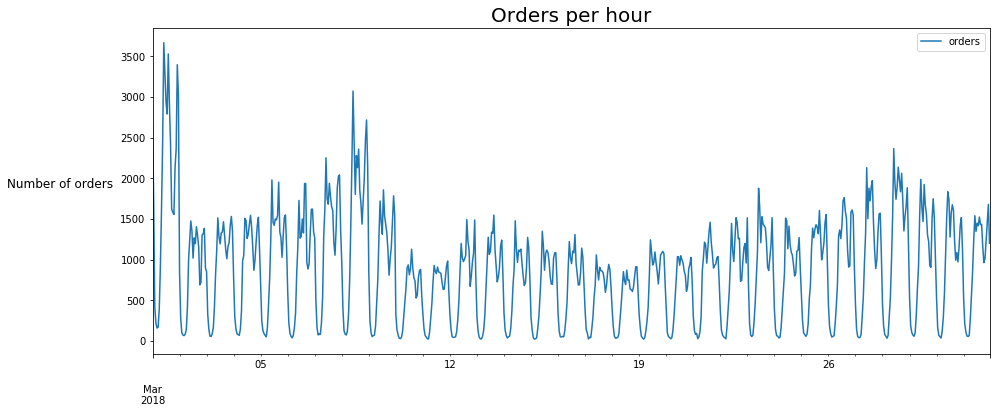

In [7]:
prepare_for_plotting(single_orders).plot(figsize = (15,6))
plt.title('Orders per hour', fontsize = 20)
plt.ylabel('Number of orders', fontsize = 12, rotation=0, labelpad=60);

# Train test split

In [8]:
variable = 'orders'
df = prepare_for_plotting(single_orders).copy()

In [9]:
def split(df):
    train_frac = 0.6845
    train_size = int(len(df) * train_frac)
    
    df_train, df_test = pd.DataFrame(df[variable])[0:train_size], pd.DataFrame(df[variable])[train_size:len(df)]

    print('Observations: %d' % (len(df)))
    print('Training Observations: %d' % (len(df_train)))
    print('Testing Observations: %d' % (len(df_test)))
    
    return df_train, df_test



In [10]:
df_train, df_test = split(df)

Observations: 744
Training Observations: 509
Testing Observations: 235


# Model Assessment

## Model Accuracy

In [11]:
# https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# https://gist.github.com/bshishov/5dc237f59f019b26145648e2124ca1c9
def mase(actual: np.ndarray, predicted: np.ndarray, training: np.ndarray, seasonality: int = 1):
    """
    Mean Absolute Scaled Error
    Baseline (benchmark) is computed with naive forecasting (shifted by @seasonality)
    """
    # I changed this to put mae(training[seasonality:], _naive_forecasting(training, seasonality))
    # on the bottom line instead of mae(actual[seasonality:], _naive_forecasting(actual, seasonality))
    return mae(actual, predicted) / mae(training[seasonality:], _naive_forecasting(training, seasonality))

def _error(actual: np.ndarray, predicted: np.ndarray):
    """ Simple error """
    return actual - predicted

def _naive_forecasting(actual: np.ndarray, seasonality: int = 1):
    """ Naive forecasting method which just repeats previous samples """
    return actual[:-seasonality]

def mae(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Absolute Error """
    return np.mean(np.abs(_error(actual, predicted)))

def model_assessment(df_test, pred, df_train):
    print('Mean squared error: %.3f' % sklearn.metrics.mean_squared_error(np.array(df_test.orders), pred))
    print('Mean absolute error: %.3f' % sklearn.metrics.mean_absolute_error(np.array(df_test.orders), pred))
    print('Mean absolute percentage error: %.3f' % mean_absolute_percentage_error(np.array(df_test.orders), pred))
    print('Mean absolute scaled error {:.3f}'.format(mase(np.array(df_test.orders), pred, np.array(df_train.orders), 24)))    
    
def plot_prediction(df_train, df_test, pred, string):
    plt.figure(figsize=(15,6))
    plt.plot(df_train[variable],  color = 'blue', linewidth = 2, label='Train')
    plt.plot(df_test[variable], color='orange', linewidth = 2, label='Test')
    #plt.plot(df_train.index, fitted, color='orange', linewidth = 2, label= "Fitted")
    plt.plot(df_test.index, pred, color='green', linewidth = 2, label = "Forecast")
    plt.title("{}".format(string), fontsize = 20)
    plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
    plt.ylabel('Orders', fontsize = 10);
    plt.legend()
    plt.show()

## Residual diagnostics

In [12]:
def residual_diagnostic(model_fit, string):
    
    # plot residual errors
    residuals = pd.DataFrame(model_fit.resid)
    fig, axes = plt.subplots(2, 2, figsize=(15,12))
    plt.title('{}'.format(string), fontsize = 20)
    fig = residuals.plot(ax=axes[0][0], title='Residual plot to examine variance and mean')
    fig = residuals.plot(kind='kde', ax=axes[0][1], title = 'PDF plot to examine normality')
    fig = sm.graphics.tsa.plot_acf(residuals, lags=100, ax=axes[1][0])
    fig = sm.graphics.tsa.plot_pacf(residuals, lags=100, ax=axes[1][1])
    fig.suptitle('{}'.format(string), fontsize=20)
    plt.show()
    # print("Small p-values means the residuals aren't white noise. BAD")
    display(sm.stats.diagnostic.acorr_ljungbox(residuals, period = 24, return_df=True).head(5))

# Transformations

In [13]:
# Box cox transformation using lambda and a power transform.
import scipy
transformed = df.copy()
transformed['power'], lam = scipy.stats.boxcox(np.array(df.orders))
transformed['log'] = np.log(df.values)
#transformed.plot()

# HOW TO UNDO THE TRANSFORMATIONS

# UNDO THE LOG TRANSFORM
# pred = scipy.special.inv_boxcox(transformed_pred, 0)

# UNDO THE POWER TRANSFORM
# pred = scipy.special.inv_boxcox(transformed_pred, scipy.stats.boxcox(np.array(df))[1])

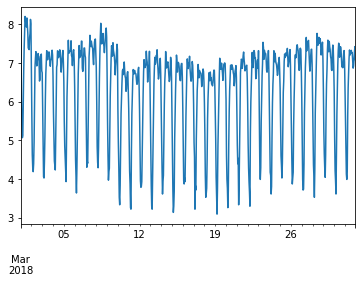

In [14]:
transformed['log'].plot()

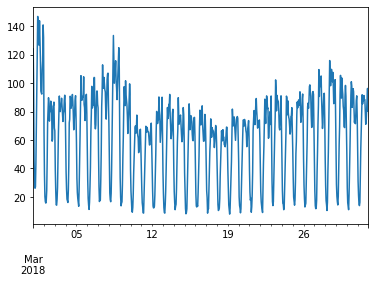

In [15]:
transformed['power'].plot()

In [16]:
train_frac = 0.6845
train_size = int(len(transformed) * train_frac)
transformed_train, transformed_test = pd.DataFrame(transformed)[0:train_size], pd.DataFrame(transformed)[train_size:len(transformed)]

print('Observations: %d' % (len(transformed)))
print('Training Observations: %d' % (len(transformed_train)))
print('Testing Observations: %d' % (len(transformed_test)))

Observations: 744
Training Observations: 509
Testing Observations: 235


# Baselines

## Average

In [17]:
pred = np.ones(len(df_test))*df_train.orders.mean()
fitted = np.ones(len(df_train))*df_train.orders.mean()

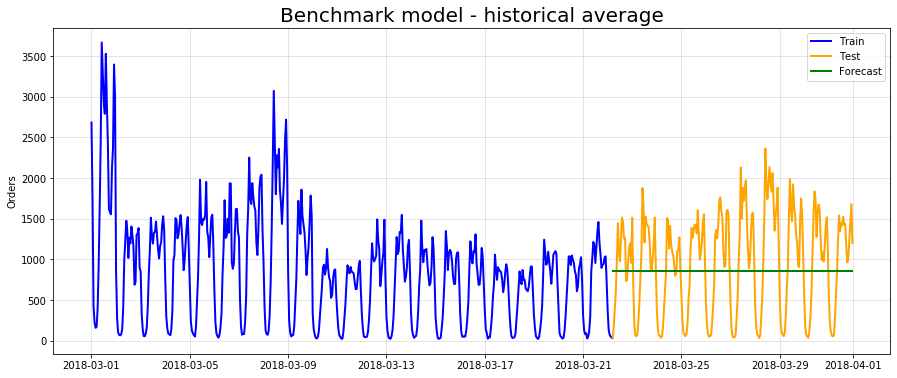

In [18]:
plot_prediction(df_train, df_test, pred, "Benchmark model - historical average")

In [19]:
model_assessment(df_test, pred, df_train)

Mean squared error: 374387.763
Mean absolute error: 535.758
Mean absolute percentage error: 263.251
Mean absolute scaled error 2.568


## Seasonal Naive Method

In [20]:
pred = np.append(np.tile(np.array(df_train['orders'][-24:].values), 9), np.array(df_train['orders'][-24:].values)[:19])

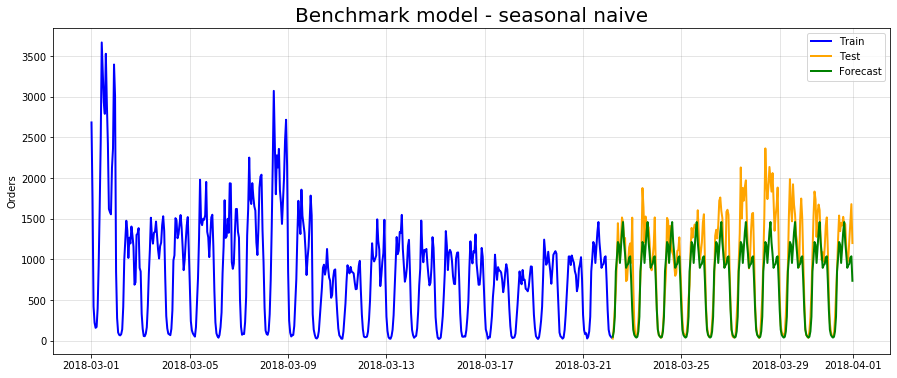

In [21]:
plot_prediction(df_train, df_test, pred, "Benchmark model - seasonal naive")

In [22]:
model_assessment(df_test, pred, df_train)

Mean squared error: 113429.183
Mean absolute error: 238.026
Mean absolute percentage error: 24.533
Mean absolute scaled error 1.141


# Exponential Smoothing

## Holt-Winters Additive Seasonality


In [23]:
model = sm.tsa.ExponentialSmoothing(df_train[variable], seasonal='add', seasonal_periods=24)
model_fit = model.fit(use_basinhopping = True,
                      use_brute = True,
                      use_boxcox = False,
                      remove_bias = False);

In [24]:
pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])

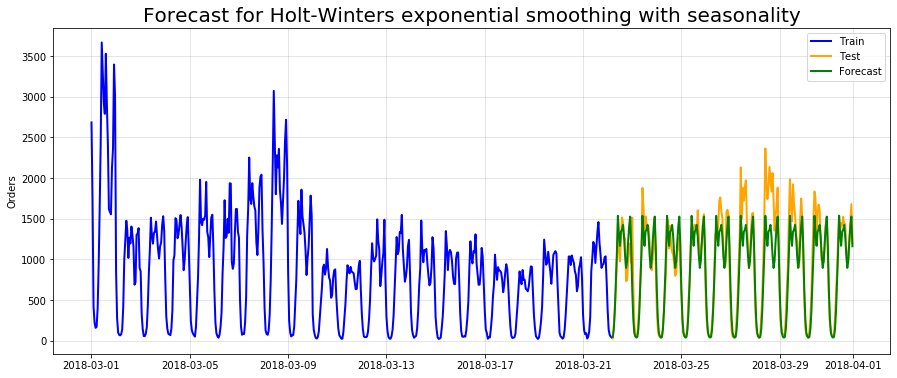

In [25]:
plot_prediction(df_train, df_test, pred, "Forecast for Holt-Winters exponential smoothing with seasonality")

In [26]:
model_assessment(df_test, pred, df_train)

Mean squared error: 59124.327
Mean absolute error: 166.279
Mean absolute percentage error: 20.460
Mean absolute scaled error 0.797


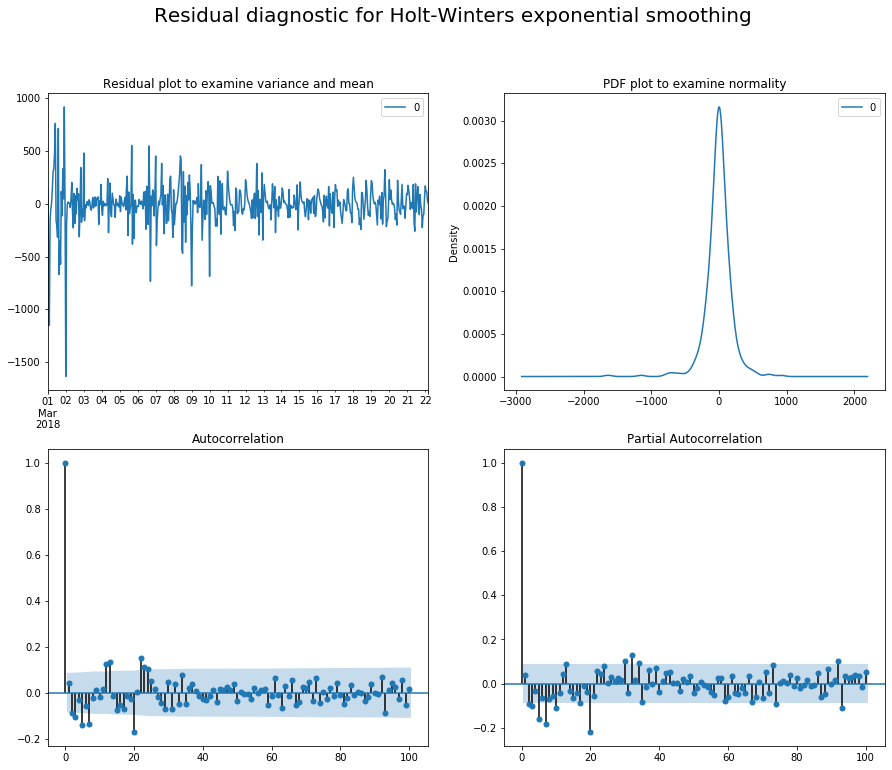

lb_stat  lb_pvalue
1   0.856092   0.354835
2   4.808731   0.090323
3  10.526421   0.014583
4  11.038287   0.026137
5  21.413183   0.000677

In [27]:
residual_diagnostic(model_fit, 'Residual diagnostic for Holt-Winters exponential smoothing')

# SARIMA model - Seasonal ARIMA

The order of the SARIMA model must be chosen. 
- Firstly, the stationarity of the data is examined to determine what level of differencing is required. One order of differencing, and one order of seasonal differencing (period 24).
- Secondly, the remaining model orders are selected by using a grid search and comparing the models using AIC and MASE.
- Thirdly, the confidence intervals are generated which raises some problems.

## Stationarity

One way to determine more objectively whether differencing is required is to use a unit root test. These are statistical hypothesis tests of stationarity that are designed for determining whether differencing is required.

**Augmented Dickey-Fuller test**
In statistics and econometrics, an augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. So, if the P-Value in ADF test is less than the significance level (0.05), you reject the null hypothesis, therefore stationary.

The second value returned is the p-value. Both of the differenced data plots are stationary.

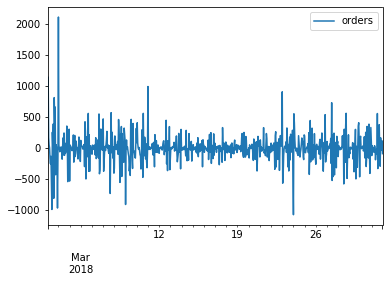

In [28]:
# seasonally difference, and then first difference the data
differenced = df.diff(24).diff().dropna()
differenced.plot();

In [29]:
sm.tsa.stattools.adfuller(differenced)

(-8.917989425260291,
 1.0598350635245987e-14,
 20,
 698,
 {'1%': -3.439753311961436,
  '5%': -2.8656896390914217,
  '10%': -2.568979777013325},
 9354.06914966448)

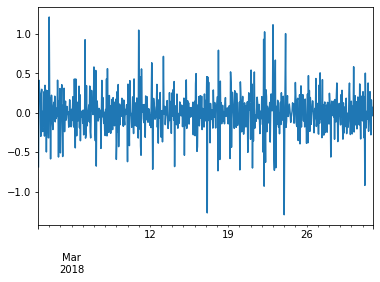

In [30]:
# seasonally difference, and then first difference the log data
differenced = transformed.log.diff(24).diff().dropna()
differenced.plot();

In [31]:
sm.tsa.stattools.adfuller(differenced)

(-14.424951527062799,
 7.799939445901766e-27,
 7,
 711,
 {'1%': -3.439580754053961,
  '5%': -2.865613606467485,
  '10%': -2.568939269723711},
 -19.21879889711454)

## Tuning SARIMA model

### Initial model order selection

To select the order of the ARIMA model we examine the autocorrelation and partial autocorrelation plots of the differenced series. Not exactly clear from the plots what order to choose, so we run a grid search.

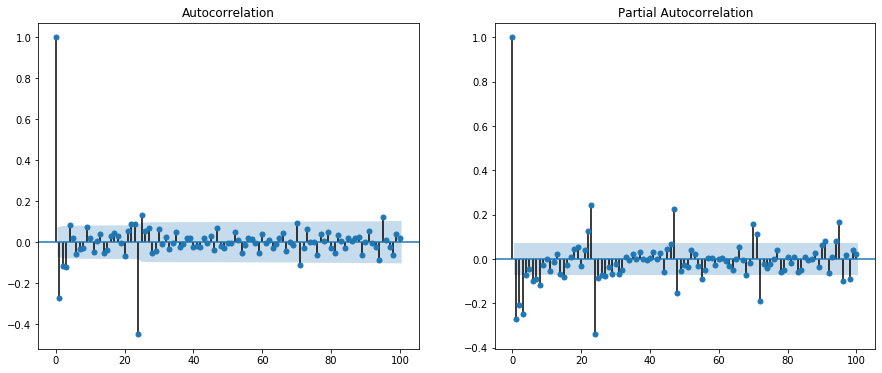

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(15,6))
sm.graphics.tsa.plot_acf(differenced, lags=100, ax=axes[0])
sm.graphics.tsa.plot_pacf(differenced, lags=100, ax=axes[1]);

### Grid search - using AIC

After running a grid search the best models were examined. Model performance was measured by AIC. You can't compare models of different differencing by AIC, or compare log transformed with normal series using AIC. 

In [33]:
# import itertools
# import warnings

In [34]:
# # Set range for p,d,q and seasonality
# p = q = range(0,5)
# d = 1
# seasonality = 24

# # Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))

# # Generate all different combinations of seasonal p, q and q triplets
# seasonal_pdq = [(x[0], x[1], x[2], seasonality) for x in list(itertools.product(p, d, q))]

In [35]:
# warnings.filterwarnings("ignore") # specify to ignore warning messages
# aic_values = list()
# for param in tqdm_notebook(pdq):
#     for param_seasonal in seasonal_pdq:
#         try:
#             mod = sm.tsa.statespace.SARIMAX(df_train[variable],
#                                             order=param,
#                                             seasonal_order=param_seasonal,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#             results = mod.fit()
#             aic_values.append(results.aic)
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             aic_values.append(np.NAN)
#             print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, np.NAN))
#             continue

In [36]:
# best_params_pdq = pdq[math.floor(aic_values.index(min(aic_values))/len(pdq))]
# best_params_seaonsal_pdq = seasonal_pdq[aic_values.index(min(aic_values)) % len(pdq)]
# print('ARIMA{}x{} - AIC:{}'.format(best_params_pdq, best_params_seaonsal_pdq, min(aic_values)))

### Comparing models using MASE

Use MASE on the test set for final selection. This means we could compare between transformed and not transformed predictions.

In [37]:
# Best model orders

# #Transformed
# model1 = [(1, 1, 1),(1, 1, 1, 24)]
# model2 = [(1, 1, 1),(1, 1, 2, 24)]

# #Not transformed
# model3 = [(0, 1, 4),(4, 1, 4, 24)]
# model4 = [(1, 1, 2),(1, 1, 4, 24)]

# models_transformed = [model1, model2]
# models = [model3,model4]

In [38]:
# for model in tqdm_notebook(models):
#     params = model[0]
#     seasonal_params = model[1]
#     mod = sm.tsa.statespace.SARIMAX(df_train,
#                                             order=params,
#                                             seasonal_order=seasonal_params,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#     model_fit = mod.fit()
#     print('ARIMA{}x{}'.format(params, seasonal_params))
#     pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
#     plot_prediction(df_train, df_test, pred)
#     model_assessment(df_test, pred, df_train)
#     residual_diagnostic(model_fit)

In [39]:
# for model in tqdm_notebook(models_transformed):
#     params = model[0]
#     seasonal_params = model[1]
#     mod = sm.tsa.statespace.SARIMAX(transformed_train.log,
#                                             order=params,
#                                             seasonal_order=seasonal_params,
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
#     model_fit = mod.fit()
#     print('ARIMA{}x{}'.format(params, seasonal_params))
#     transformed_pred = model_fit.predict(start=transformed_test.index[0], end=transformed_test.index[-1])
#     pred = scipy.special.inv_boxcox(transformed_pred, 0)
#     plot_prediction(df_train, df_test, pred)
#     model_assessment(df_test, pred, df_train)
#     residual_diagnostic(model_fit)

### Best model

Transformed

ARIMA(1, 1, 1)x(1, 1, 1, 24)

- Mean squared error: 88187.723
- Mean absolute error: 202.390
- Mean absolute percentage error: 20.359
- Mean absolute scaled error 0.970

In [40]:
model = sm.tsa.statespace.SARIMAX(transformed_train.log, order=(1,1,1), seasonal_order=(1, 1, 1, 24),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
model_fit = model.fit()
transformed_pred = model_fit.predict(start=transformed_test.index[0], end=transformed_test.index[-1])
pred = scipy.special.inv_boxcox(transformed_pred, 0)
#display(model_fit.summary())

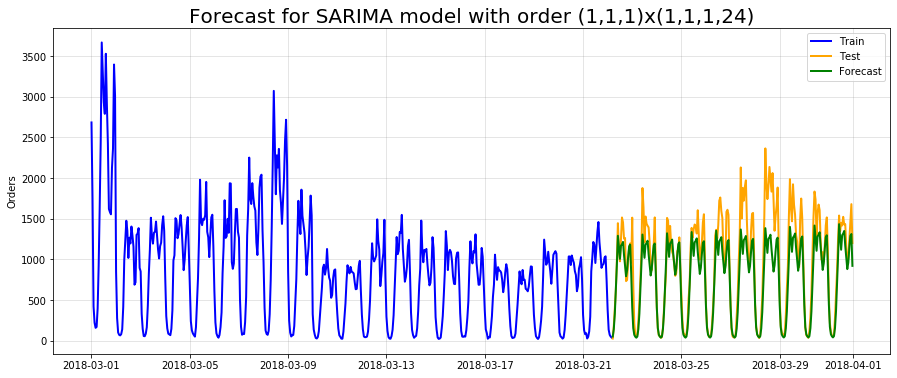

In [41]:
plot_prediction(df_train, df_test, pred, "Forecast for SARIMA model with order (1,1,1)x(1,1,1,24)")

In [42]:
model_assessment(df_test, pred, df_train)

Mean squared error: 88187.723
Mean absolute error: 202.390
Mean absolute percentage error: 20.359
Mean absolute scaled error 0.970


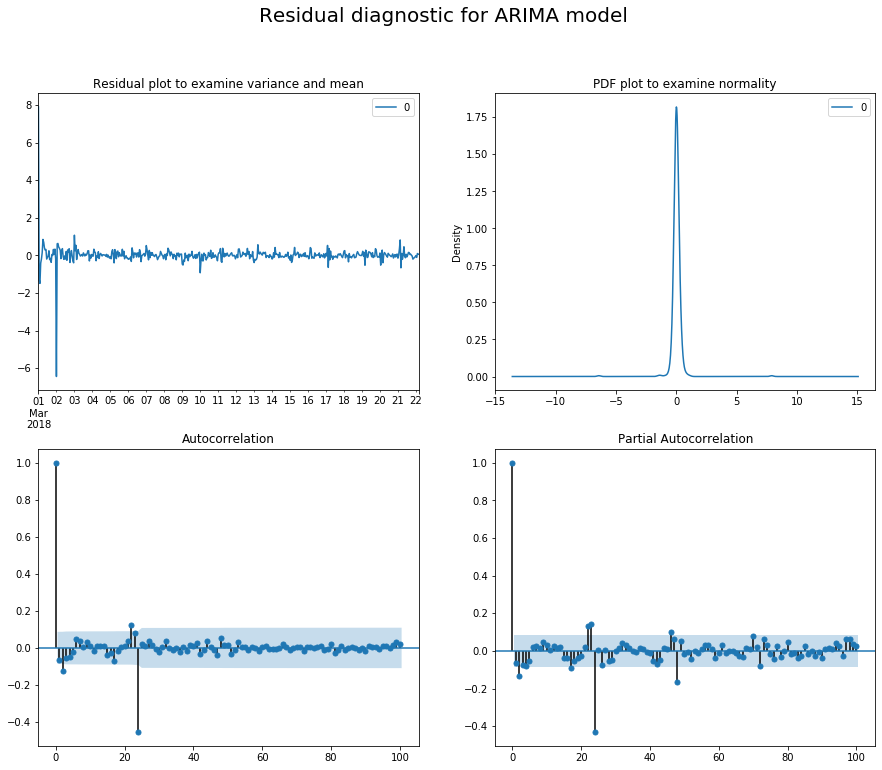

lb_stat  lb_pvalue
1   2.171805   0.140561
2  10.359935   0.005628
3  11.900524   0.007732
4  13.077467   0.010903
5  13.337806   0.020411

In [43]:
residual_diagnostic(model_fit, 'Residual diagnostic for ARIMA model')

## Confidence intervals for the SARIMA model

The best model uses log transformed values. This is a problem when confidence intervals are generated, because when the values are back transformed they increase exponentially. The code to produce the confidence intervals for the second best model are also provided (these aren't log transformed so don't have the same problem, they are commented out).

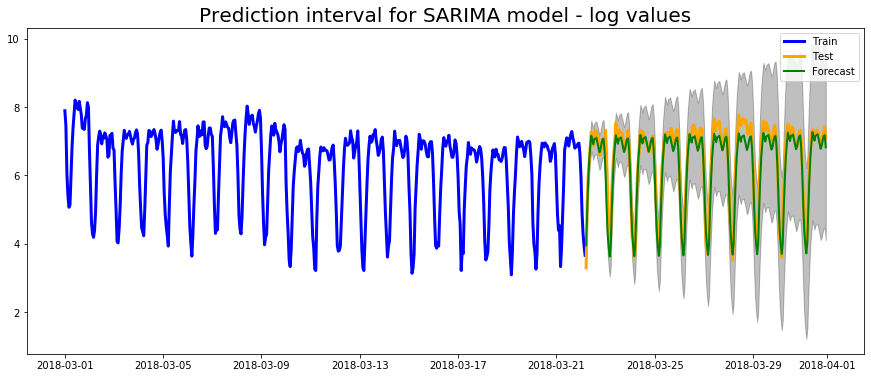

In [44]:
pred_uc = model_fit.get_forecast(steps=len(df_test))
fcst = pred_uc.predicted_mean
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

plt.figure(figsize = (15,6))
ax = plt.plot(transformed_train.log,  color = 'blue', linewidth = 3, label='Train')
plt.plot(transformed_test.log, color='orange', linewidth = 3, label='Test')
plt.plot(pd.to_datetime(fcst.index, format = '%d/%m/%Y'), pd.DataFrame(fcst).loc[:,0], color='green', linewidth = 2, label = "Forecast")
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Prediction interval for SARIMA model - log values', fontsize = 20)
plt.legend()
plt.show()

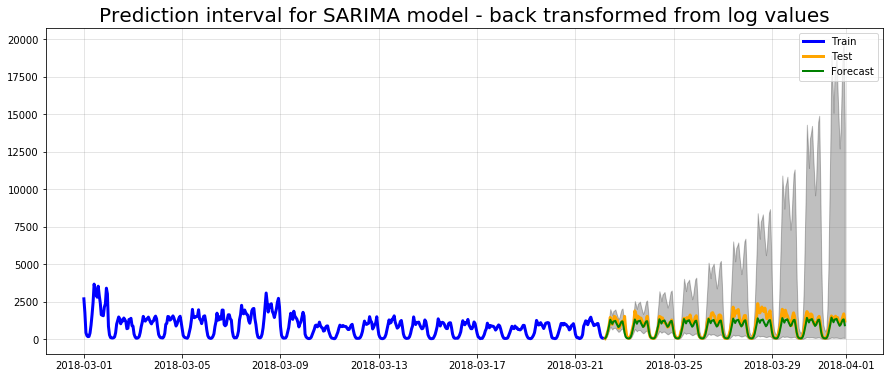

In [45]:
pred_uc = model_fit.get_forecast(steps=len(df_test))
fcst = pred_uc.predicted_mean
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

pred_ci['lower log'] = scipy.special.inv_boxcox(np.array(pred_ci['lower log'].values), 0)
pred_ci['upper log'] = scipy.special.inv_boxcox(np.array(pred_ci['upper log'].values), 0)
fcst = scipy.special.inv_boxcox(pred_uc.predicted_mean, 0)

plt.figure(figsize = (15,6))
ax = plt.plot(df_train[variable],  color = 'blue', linewidth = 3, label='Train')
plt.plot(df_test[variable], color='orange', linewidth = 3, label='Test')
plt.plot(pd.to_datetime(fcst.index, format = '%d/%m/%Y'), pd.DataFrame(fcst).loc[:,0], color='green', linewidth = 2, label = "Forecast")
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
plt.title('Prediction interval for SARIMA model - back transformed from log values', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)

plt.legend()
plt.show()

In [46]:
# # next best model that isn't log transformed, so the prediction intervals
# # are not massive

# model = sm.tsa.statespace.SARIMAX(df_train[variable], order=(1,1,2), seasonal_order=(1, 1, 4, 24),
#                                             enforce_stationarity=False,
#                                             enforce_invertibility=False)
# model_fit = model.fit()
# pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
# #display(model_fit.summary())

In [47]:
# plot_prediction(df_train, df_test, pred, "Forecast for SARIMA model with order (1,1,2)x(1,1,4,24)")

In [48]:
# model_assessment(df_test, pred, df_train)

In [49]:
# residual_diagnostic(model_fit)

In [50]:
# pred_uc = model_fit.get_forecast(steps=len(df_test))
# fcst = pred_uc.predicted_mean
# # Get confidence intervals of forecasts
# pred_ci = pred_uc.conf_int()

# plt.figure(figsize = (15,6))
# ax = plt.plot(df_train[variable],  color = 'blue', linewidth = 3, label='Train')
# plt.plot(df_test[variable], color='orange', linewidth = 3, label='Test')
# plt.plot(pd.to_datetime(fcst.index, format = '%d/%m/%Y'), pd.DataFrame(fcst).loc[:,0], color='green', linewidth = 2, label = "Forecast")
# plt.fill_between(pred_ci.index,
#                 pred_ci.iloc[:, 0],
#                 pred_ci.iloc[:, 1], color='k', alpha=.25)
# plt.legend()
# plt.show()

# Facebook's Prophet model

Requires the data to be in a specific format

In [51]:
df_train.reset_index(inplace=True)
df_train.rename(columns={'index':'ds', 'orders':'y'}, inplace=True)

In [52]:
df_train

ds     y
0   2018-03-01 00:00:00  2683
1   2018-03-01 01:00:00  1748
2   2018-03-01 02:00:00   421
3   2018-03-01 03:00:00   222
4   2018-03-01 04:00:00   159
..                  ...   ...
504 2018-03-22 00:00:00   381
505 2018-03-22 01:00:00   136
506 2018-03-22 02:00:00    73
507 2018-03-22 03:00:00    51
508 2018-03-22 04:00:00    39

[509 rows x 2 columns]

In [53]:
m = Prophet(weekly_seasonality=False,
            daily_seasonality=True,
            yearly_seasonality=False,
            changepoint_prior_scale=0.2)

In [54]:
m.fit(df_train);

In [55]:
future = m.make_future_dataframe(periods=235, freq='H')

In [56]:
forecast = m.predict(future)

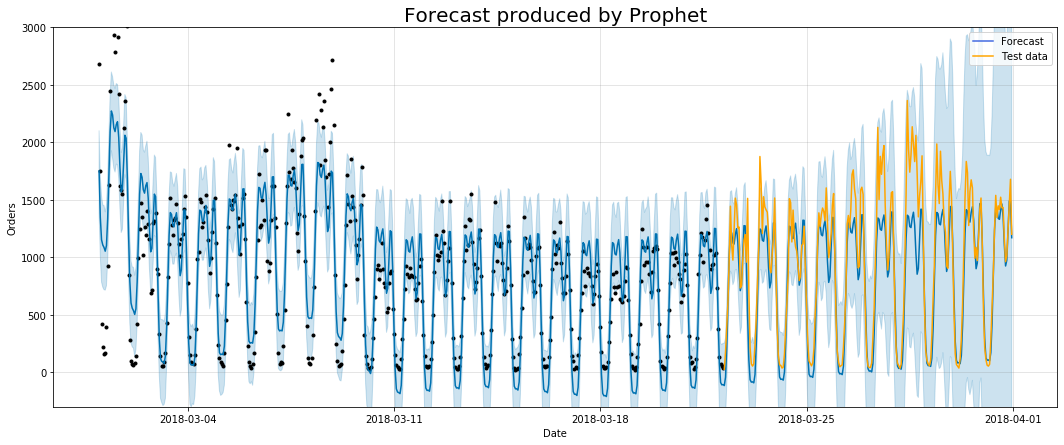

In [57]:
from fbprophet.plot import plot
fig = plot(m, forecast, figsize=(15, 6), xlabel='Date', ylabel='Orders');
# plt.plot(data = forecast.yhat, index = forecast.ds, label = 'Forecast', color='red')
ax = fig.gca()
ax.set_ylim(-300, 3000)
plt.title('Forecast produced by Prophet', fontsize = 20)

import matplotlib.lines as mlines
test, = plt.plot(df_test, color='orange', label = 'Test data')
blue_line = mlines.Line2D([], [], color='royalblue', label='Forecast')
plt.legend(handles=[blue_line, test]);

In [58]:
pred = forecast['yhat'][509:]

print('Mean squared error: %.3f' % sklearn.metrics.mean_squared_error(np.array(df_test.orders), np.array(pred)))
print('Mean absoloute error: %.3f' % sklearn.metrics.mean_absolute_error(np.array(df_test.orders), np.array(pred)))
print('Mean absoloute percent error: %.3f' % mean_absolute_percentage_error(np.array(df_test.orders), np.array(pred)))
print('Mean absolute scaled error {:.3f}'.format(mase(np.array(df_test.orders), np.array(pred), np.array(df_train.y), 24)))

Mean squared error: 69323.772
Mean absoloute error: 182.659
Mean absoloute percent error: 35.277
Mean absolute scaled error 0.876


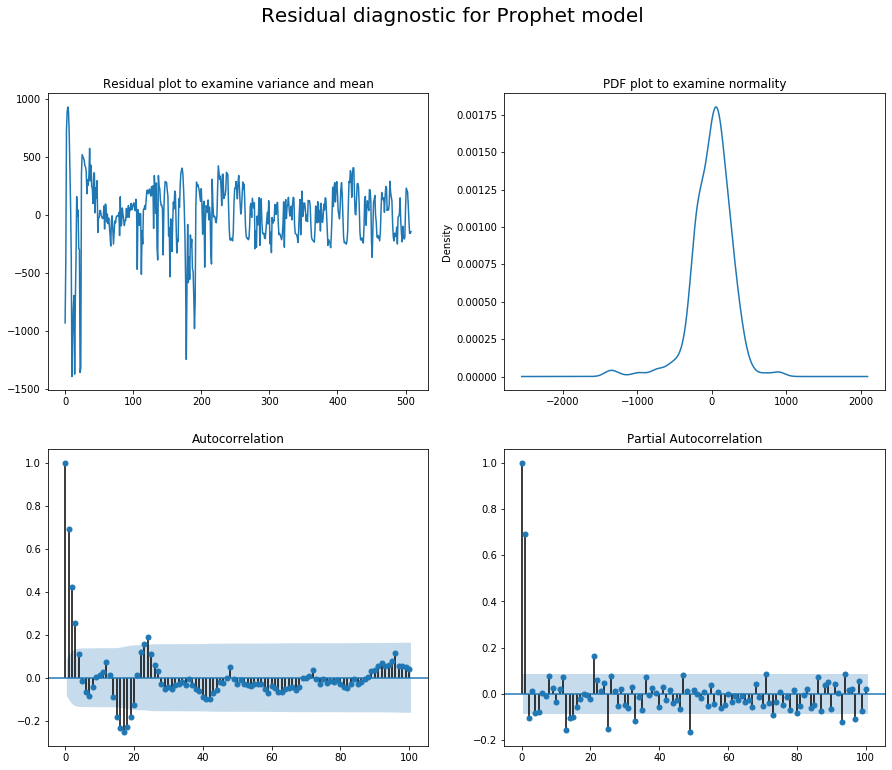

In [59]:
residuals = forecast.yhat[:509] - df_train.y

fig, axes = plt.subplots(2, 2, figsize=(15,12))

fig = residuals.plot(ax=axes[0][0], title='Residual plot to examine variance and mean')
fig = residuals.plot(kind='kde', ax=axes[0][1], title = 'PDF plot to examine normality')
fig = sm.graphics.tsa.plot_acf(residuals, lags=100, ax=axes[1][0])
fig = sm.graphics.tsa.plot_pacf(residuals, lags=100, ax=axes[1][1])
fig.suptitle('Residual diagnostic for Prophet model', fontsize=20)
plt.show()

# Functions for quick experimentaion

In [60]:
def exponential_smoothing(df_train, df_test):
    model = sm.tsa.ExponentialSmoothing(df_train[variable], seasonal='add', seasonal_periods=24)
    model_fit = model.fit(use_basinhopping = True,
                      use_brute = True,
                      use_boxcox = False,
                      remove_bias = False);
    pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
    plot_prediction(df_train, df_test, pred, "Forecast for Holt-Winters exponential smoothing with seasonality")
    model_assessment(df_test, pred, df_train)

In [61]:
def sarima(df_train, df_test):

    model = sm.tsa.statespace.SARIMAX(df_train[variable], order=(1,1,2), seasonal_order=(1, 1, 4, 24),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
    model_fit = model.fit()
    pred = model_fit.predict(start=df_test.index[0], end=df_test.index[-1])
    
    plot_prediction(df_train, df_test, pred, "Forecast for SARIMA model with order (1,1,2)x(1,1,4,24)")
    
    model_assessment(df_test, pred, df_train)

In [62]:
def prophet(df_train, df_test):
    df_train.reset_index(inplace=True)
    df_train.rename(columns={'index':'ds', 'orders':'y'}, inplace=True)
    
    m = Prophet(weekly_seasonality=False,
            daily_seasonality=True,
            yearly_seasonality=False,
            changepoint_prior_scale=0.2)
    m.fit(df_train);
    future = m.make_future_dataframe(periods=235, freq='H')
    forecast = m.predict(future)

    from fbprophet.plot import plot
    fig = plot(m, forecast, figsize=(15, 6), xlabel='Date', ylabel='Orders');
    # plt.plot(data = forecast.yhat, index = forecast.ds, label = 'Forecast', color='red')
    ax = fig.gca()
    plt.title('Forecast produced by Prophet', fontsize = 20)

    import matplotlib.lines as mlines
    test, = plt.plot(df_test, color='orange', label = 'Test data')
    blue_line = mlines.Line2D([], [], color='royalblue', label='Forecast')
    plt.legend(handles=[blue_line, test]);
    plt.show()
    
    pred = forecast['yhat'][509:]

    print('Mean squared error: %.3f' % sklearn.metrics.mean_squared_error(np.array(df_test.orders), np.array(pred)))
    print('Mean absoloute error: %.3f' % sklearn.metrics.mean_absolute_error(np.array(df_test.orders), np.array(pred)))
    print('Mean absoloute percent error: %.3f' % mean_absolute_percentage_error(np.array(df_test.orders), np.array(pred)))
    print('Mean absolute scaled error {:.3f}'.format(mase(np.array(df_test.orders), np.array(pred), np.array(df_train.y), 24)))

In [63]:
def forecast_all(df):
    df_train, df_test = split(df)
    exponential_smoothing(df_train, df_test)
    # SARIMA takes longer to run, so is commented out to make experimentation faster
    #sarima(df_train, df_test)
    prophet(df_train, df_test)

# Experiment 2: Product Type Aggregation

Features of SKUs that can be used to aggregate

- Type
- Price 
- Brand
- Best selling
- Attribute 1 and attribute 2

All of these aggregation groups are manually curated, and predictions are made on each of these groups manually, these predictions are compared manually as well. 

Only type is shown as an example.

Then a k-means clustering algorithm is used to automatically cluster the products and predictions are made on these clusters.

- K-means clustering

In [64]:
# 'skus' table
skus = pd.read_csv('../Data/JD_sku_data.csv')

## Type

In [65]:
skus.type.value_counts()

2    30701
1     1167
Name: type, dtype: int64

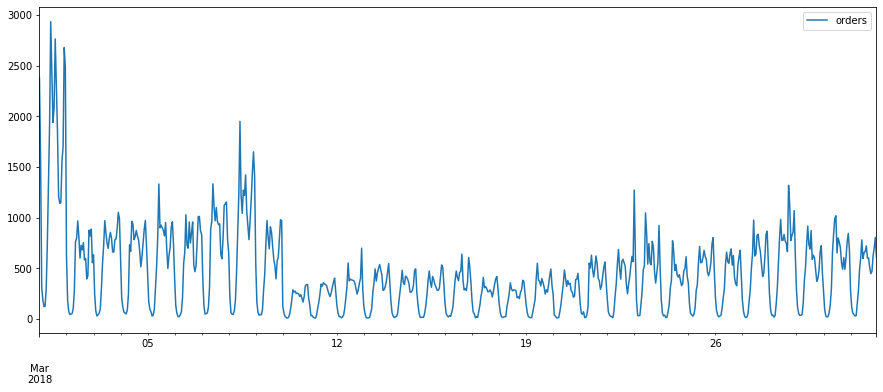

In [66]:
orders_type1 = single_orders[single_orders.type == 1]
orders_type1 = prepare_for_plotting(orders_type1)
orders_type1.plot(figsize = (15,6));

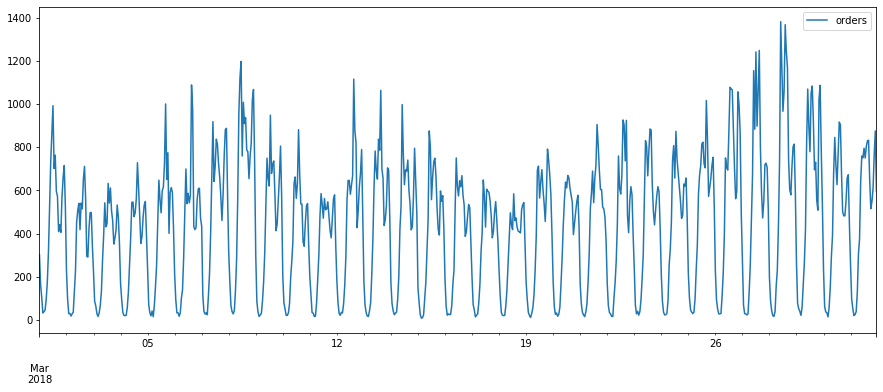

In [67]:
orders_type2 = single_orders[single_orders.type == 2]
orders_type2 = prepare_for_plotting(orders_type2)
orders_type2.plot(figsize = (15,6));

Observations: 744
Training Observations: 509
Testing Observations: 235


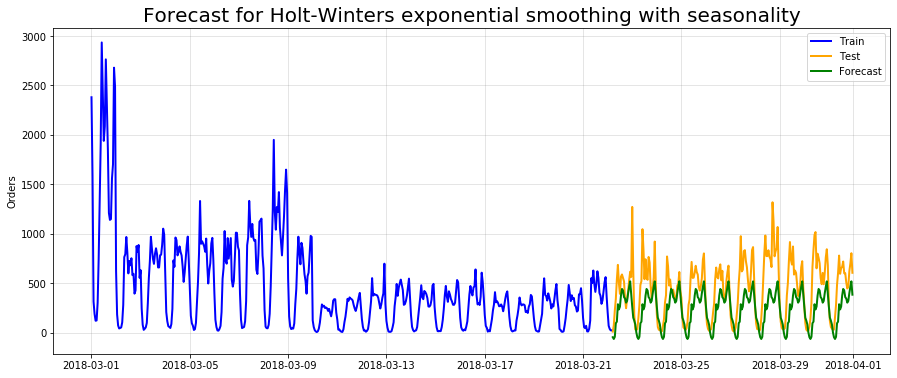

Mean squared error: 90308.740
Mean absolute error: 231.710
Mean absolute percentage error: 74.744
Mean absolute scaled error 1.570


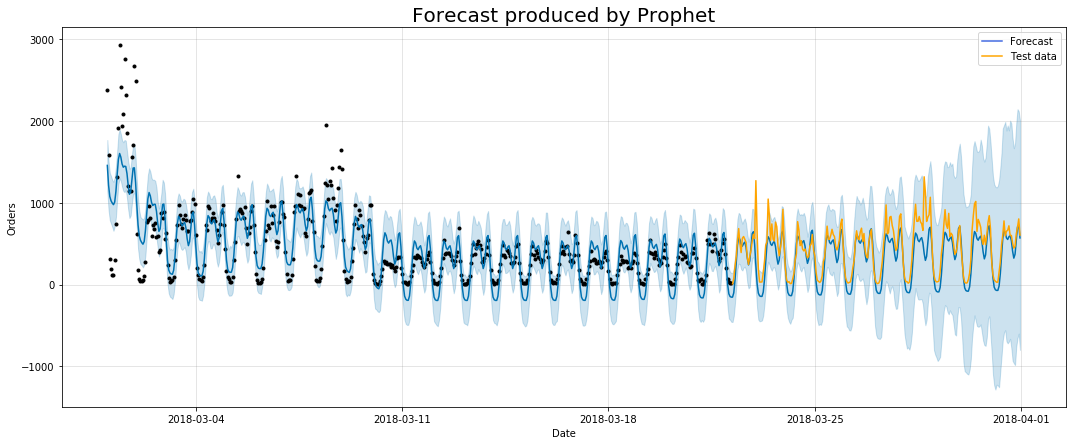

Mean squared error: 35416.918
Mean absoloute error: 134.431
Mean absoloute percent error: 97.990
Mean absolute scaled error 0.911


In [68]:
forecast_all(orders_type1)

Observations: 744
Training Observations: 509
Testing Observations: 235


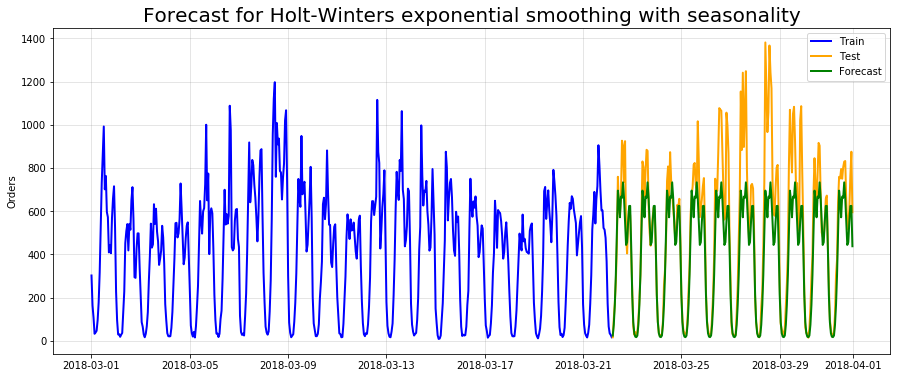

Mean squared error: 32263.668
Mean absolute error: 114.763
Mean absolute percentage error: 21.463
Mean absolute scaled error 1.417


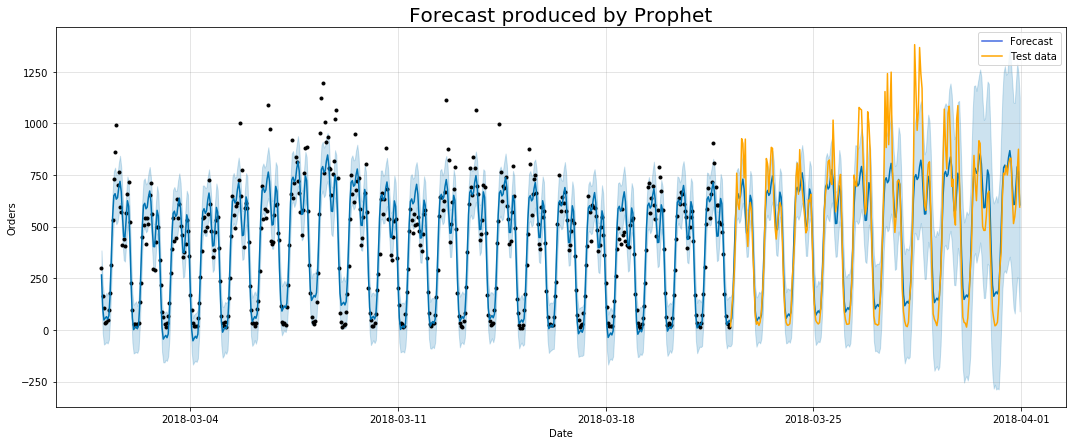

Mean squared error: 20793.692
Mean absoloute error: 96.494
Mean absoloute percent error: 60.507
Mean absolute scaled error 1.191


In [69]:
forecast_all(orders_type2)

## K-means clustering

In [83]:
# convert values to zero, instead of strings of '-'
skus.attribute1 = [0 if item == '-' else float(item) for item in skus.attribute1]
skus.attribute2 = [0 if item == '-' else float(item) for item in skus.attribute2]

In [84]:
# add price column to the SKUs dataframe
skus_copy = skus.copy()
sku_price = orders[['sku_ID', 'original_unit_price']].copy()
sku_price = skus_copy.merge(sku_price)
sku_price = sku_price.drop_duplicates()

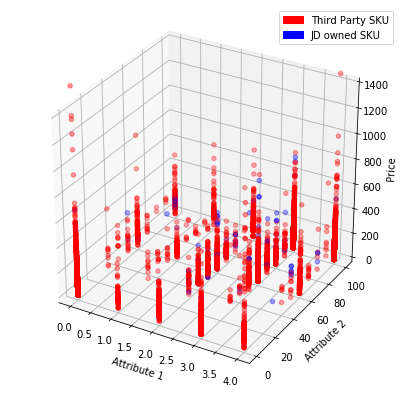

In [88]:
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection="3d")
ax.scatter3D(np.array(sku_price.attribute1), np.array(sku_price.attribute2), np.array(sku_price.original_unit_price),  
             c = np.array(sku_price.type), cmap = 'bwr' );
ax.set_zlim([-10, 1400])
third_party = mpatches.Circle((0, 0), color = 'red', label='Third Party SKU')
JD_owned = mpatches.Circle((0,0), color='blue', label='JD owned SKU')
plt.legend(handles=[third_party, JD_owned]);
ax.set_xlabel('Attribute 1')
ax.set_ylabel('Attribute 2')
ax.set_zlabel('Price')
plt.show()

In [89]:
# numerical features to be used for clustering
num_features_skus = sku_price[['attribute1', 'attribute2', 'original_unit_price', 'type']].copy()

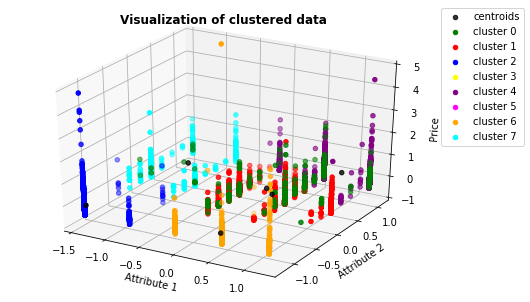

In [90]:
X = np.array(num_features_skus)

X_std = StandardScaler().fit_transform(X)

km = KMeans(n_clusters=8, max_iter=100).fit(X_std)

centroids = km.cluster_centers_

# Plot the clustered data
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], color = 'black', label = 'centroids', alpha = 0.8)

# km.labels_ == 0 gives a true false array of which are in cluster 0
# and the ,0 says it's in the first column
ax.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1,], X_std[km.labels_ == 0, 2],
            c='green', label='cluster 0')
ax.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1,], X_std[km.labels_ == 1, 2],
            c='red', label='cluster 1')
ax.scatter(X_std[km.labels_ == 2, 0], X_std[km.labels_ == 2, 1,], X_std[km.labels_ == 2, 2],
            c='blue', label='cluster 2')
ax.scatter(X_std[km.labels_ == 3, 0], X_std[km.labels_ == 3, 1,], X_std[km.labels_ == 3, 2],
            c='yellow', label='cluster 3')
ax.scatter(X_std[km.labels_ == 4, 0], X_std[km.labels_ == 4, 1,], X_std[km.labels_ == 4, 2],
            c='purple', label='cluster 4')
ax.scatter(X_std[km.labels_ == 5, 0], X_std[km.labels_ == 5, 1,], X_std[km.labels_ == 5, 2],
            c='magenta', label='cluster 5')
ax.scatter(X_std[km.labels_ == 6, 0], X_std[km.labels_ == 6, 1,], X_std[km.labels_ == 6, 2],
            c='orange', label='cluster 6')
ax.scatter(X_std[km.labels_ == 7, 0], X_std[km.labels_ == 7, 1,], X_std[km.labels_ == 7, 2],
            c='cyan', label='cluster 7')

plt.legend(loc = 'lower center', bbox_to_anchor=(1.1, 0.5))
ax.set_xlabel('Attribute 1')
ax.set_ylabel('Attribute 2')
ax.set_zlabel('Price')
ax.set_zlim([-1, 5])
plt.title('Visualization of clustered data', fontweight='bold');

In [91]:
# assign the cluster label to the SKU dataframe that also includes the price
sku_price.reset_index(inplace=True, drop = True)
sku_price['cluster'] = km.labels_

In [92]:
# some clusters don't have enough SKUs to bother with
sku_price.cluster.value_counts()

4    3205
2    2643
1    2282
6     731
0     625
7     464
5       7
3       4
Name: cluster, dtype: int64

In [93]:
# because the number label of the clusters changes each time the clustering is done
# simply assigning letters to the cluster variable names here

# also only using the first 6 clusters because the others don't have enough SKUs to bother with

clusterA = sku_price[sku_price.cluster == sku_price.cluster.value_counts().index[0]]
clusterB = sku_price[sku_price.cluster == sku_price.cluster.value_counts().index[1]]
clusterC = sku_price[sku_price.cluster == sku_price.cluster.value_counts().index[2]]
clusterD = sku_price[sku_price.cluster == sku_price.cluster.value_counts().index[3]]
clusterE = sku_price[sku_price.cluster == sku_price.cluster.value_counts().index[4]]
clusterF = sku_price[sku_price.cluster == sku_price.cluster.value_counts().index[5]]

orders_clusterA = single_orders[single_orders.sku_ID.isin(clusterA.sku_ID)]
orders_clusterB = single_orders[single_orders.sku_ID.isin(clusterB.sku_ID)]
orders_clusterC = single_orders[single_orders.sku_ID.isin(clusterC.sku_ID)]
orders_clusterD = single_orders[single_orders.sku_ID.isin(clusterD.sku_ID)]
orders_clusterE = single_orders[single_orders.sku_ID.isin(clusterE.sku_ID)]
orders_clusterF = single_orders[single_orders.sku_ID.isin(clusterF.sku_ID)]

Observations: 744
Training Observations: 509
Testing Observations: 235


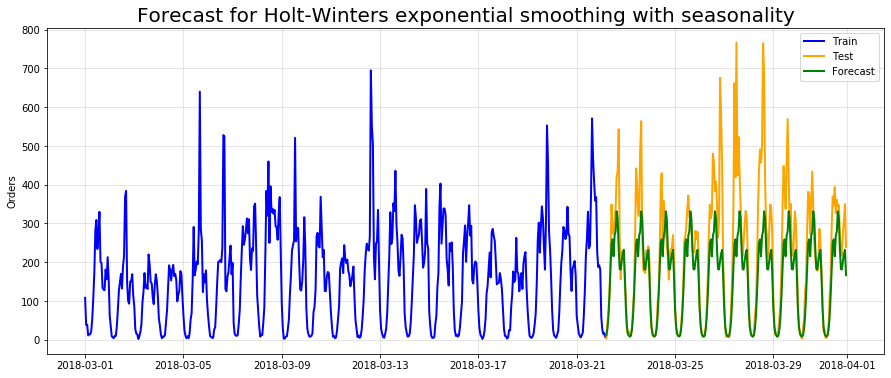

Mean squared error: 12004.692
Mean absolute error: 67.126
Mean absolute percentage error: 27.958
Mean absolute scaled error 1.415


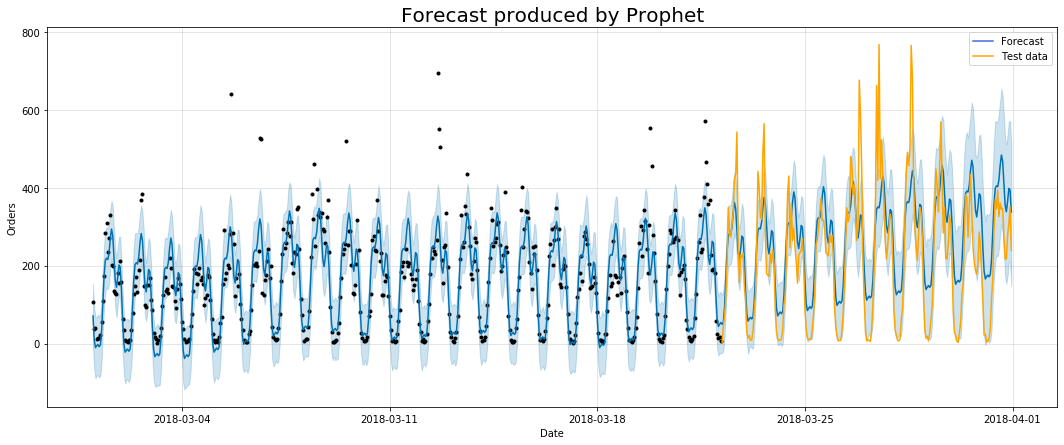

Mean squared error: 10436.470
Mean absoloute error: 81.687
Mean absoloute percent error: 235.007
Mean absolute scaled error 1.721


In [94]:
forecast_all(prepare_for_plotting(orders_clusterA))

Observations: 744
Training Observations: 509
Testing Observations: 235


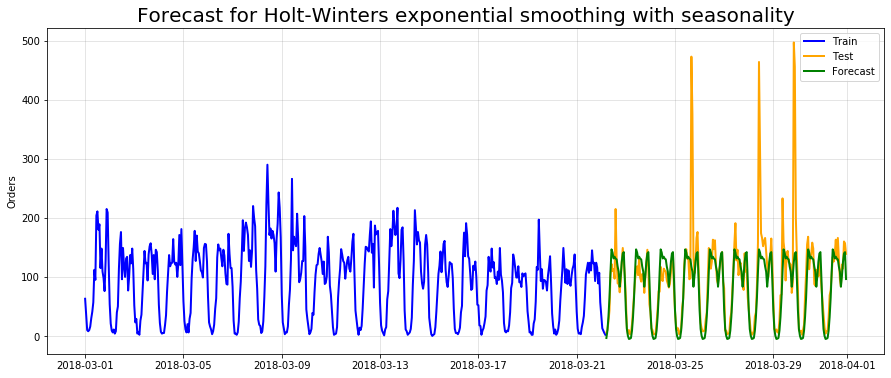

Mean squared error: 2939.025
Mean absolute error: 24.491
Mean absolute percentage error: 45.579
Mean absolute scaled error 1.241


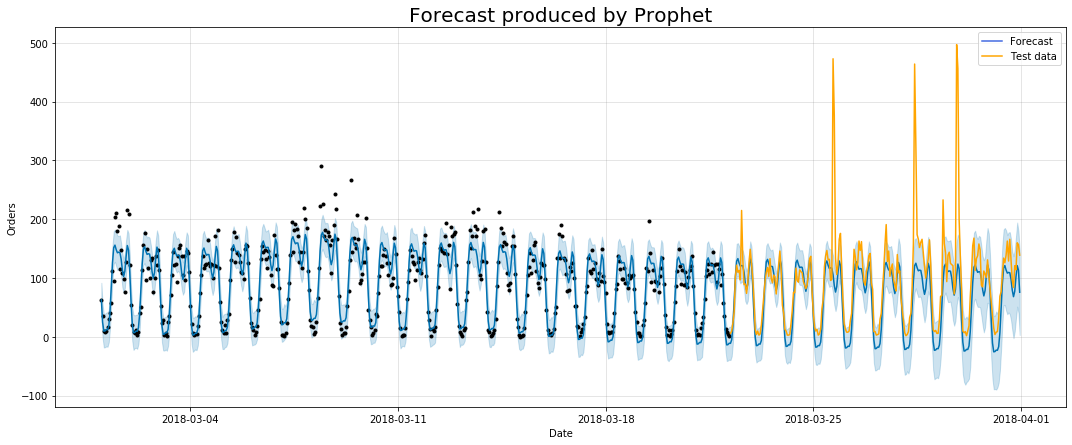

Mean squared error: 3677.661
Mean absoloute error: 32.925
Mean absoloute percent error: 99.987
Mean absolute scaled error 1.669


In [95]:
forecast_all(prepare_for_plotting(orders_clusterB))

### Weekly pattern

A weekly pattern was spotted in one of the clusters, with a weekly peak every Thursday.

Unfortunately the clusters that produced the most pronounced weekly pattern for cluster C weren't manually saved, so every time the notebook is run, different clusters are produced and cluster C might not necessarily have a strong weekly pattern with a peak on a Thursday. The original weekly pattern was saved and the graph was used in my thesis.

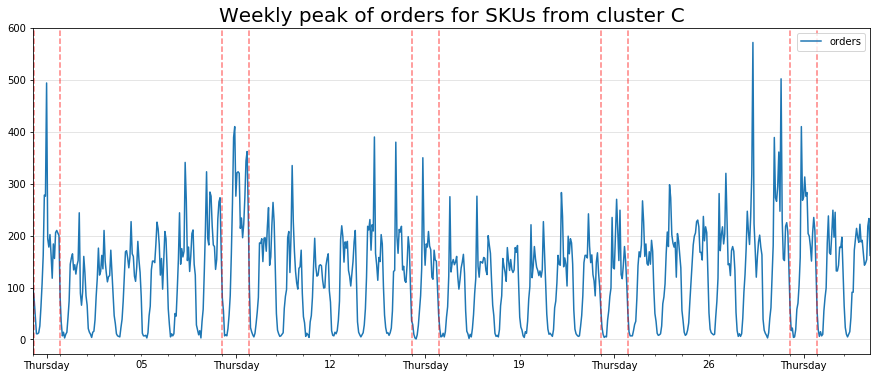

In [96]:
(prepare_for_plotting(orders_clusterC)).plot(figsize = (15,6))
thursday = ['Thursday', 'Thursday', 'Thursday', 'Thursday', 'Thursday']
plt.title("Weekly peak of orders for SKUs from cluster C", fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'y', color = 'grey', alpha = 0.25)
plt.axvline(datetime.datetime(2018,3,1,1), linestyle='--', color = 'red', alpha = 0.5)
plt.axvline(datetime.datetime(2018,3,2,0), linestyle='--', color = 'red', alpha = 0.5)
plt.axvline(datetime.datetime(2018,3,8,0), linestyle='--', color = 'red', alpha = 0.5)
plt.axvline(datetime.datetime(2018,3,9,0), linestyle='--', color = 'red', alpha = 0.5)
plt.axvline(datetime.datetime(2018,3,15,0), linestyle='--', color = 'red', alpha = 0.5)
plt.axvline(datetime.datetime(2018,3,16,0), linestyle='--', color = 'red', alpha = 0.5)
plt.axvline(datetime.datetime(2018,3,22,0), linestyle='--', color = 'red', alpha = 0.5)
plt.axvline(datetime.datetime(2018,3,23,0), linestyle='--', color = 'red', alpha = 0.5)
plt.axvline(datetime.datetime(2018,3,29,0), linestyle='--', color = 'red', alpha = 0.5)
plt.axvline(datetime.datetime(2018,3,30,0), linestyle='--', color = 'red', alpha = 0.5)


ticks = [datetime.datetime(2018,3,1,12), datetime.datetime(2018,3,8,12), datetime.datetime(2018,3,15,12), datetime.datetime(2018,3,22,12), datetime.datetime(2018,3,29,12)]


plt.xticks(ticks= ticks, labels = thursday);


plt.show()


### Order clustering 

The order table was plotted to examine if clustering of orders would be beneficial, it was decided that it would not be.

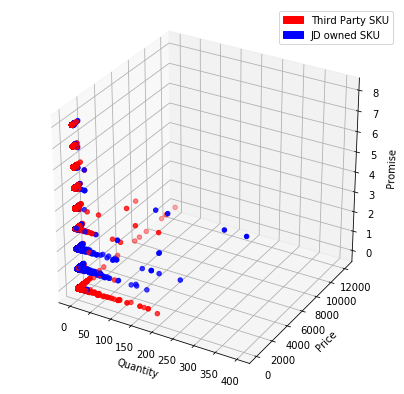

In [98]:
num_features_orders = orders[['quantity', 'type', 'promise', 'original_unit_price']].copy()
num_features_orders['promise'] = [0 if promise == '-' else int(promise) for promise in num_features_orders['promise']]

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, projection='3d')

x = np.array(num_features_orders.quantity)
y = np.array(num_features_orders.original_unit_price)
z = np.array(num_features_orders.promise)
c = np.array(num_features_orders.type)

img = ax.scatter(x, y, z, c=c, cmap='bwr')
#fig.colorbar(img)

ax.set_xlabel('Quantity')
ax.set_ylabel('Price')
ax.set_zlabel('Promise')

# import matplotlib.lines as mlines
third_party = mpatches.Circle((0, 0), color = 'red', label='Third Party SKU')
JD_owned = mpatches.Circle((0,0), color='blue', label='JD owned SKU')
plt.legend(handles=[third_party, JD_owned]);
plt.show()

# Experiment 3: Customer based aggregation

In [99]:
# 'users' table
users = pd.read_csv('../Data/JD_user_data.csv')

The attributes of the user table are listed here.

- user level
- plus
- gender
- age
- marital_status
- education
- city_level
- purchase_power

Instead of manually curating groups within each attribute, this is done automatically within a for loop. Each attribute is categorical in nature, so is aggregated categorically.

None of the aggregations resulted in a significant increase in forecast accuracy.

In [100]:
important_columns = ['user_level', 'plus', 'gender', 'age', 'marital_status', 'education', 'city_level', 'purchase_power']

In [101]:
# for column in important_columns:
#     print(column)
#     print('Value Counts')
#     series = users[column].value_counts()
#     print(series)
#     for index in series.index:
#         print('''
#     Column:{}
#     Index:{}
#     Number of users:{}'''.format(column, index, series[index]))
#         users_ = users[users['{}'.format(column)] == index]
#         single_orders_ = single_orders[single_orders.user_ID.isin(users_.user_ID)]
#         plot_ = prepare_for_plotting(single_orders_)
#         print('Number of {}'.format(plot_.sum()))
#         plot_.plot()
#         plt.show()
#         forecast_all(plot_)
#         plt.show()

## Effect of International Women's Day

One abnormality that was found when comparing the demand pattern of each gender was that there was
a large spike in orders by women, but not men, on the 8th of March. The most plausible explanation is
that the 8th of March is International Women’s Day. In China women get a half day from work on
International Women’s Day, which may have led to more online shopping as they had more free time.

This International Women’s Day example has a broader implication. George Box, the same
statistician who developed the Box-Cox transformation and the Ljung-Box test which were used in this
analysis, said “All models are wrong, but some are useful”. The International Women’s Day example
demonstrates this fact, the model was not able to account for the increase in demand due to a holiday.
Some models, like the Prophet model, can incorporate holidays, however another method to take
holidays into account is to adjust forecasts using judgement.These adjustments should be made with caution, as previous work on
judgemental adjustments to forecasts shows that large negative adjustments generally improve 
forecast accuracy, and large positive adjustments are detrimental to forecast accuracy.  However, those studies examine adjustments in the general case and not for specific events, such as holidays. In the case of specific events, such as holidays, it is recommended that JD.com use experienced judgement to adjust forecasts. 

In [102]:
def prepare_for_plotting_days(df):
    df = pd.DataFrame(df['order_date'])

    # change the string values to datetime and set it as the index
    df['order_date'] = pd.to_datetime(df['order_date'])
    df.set_index('order_date', inplace=True)

    # value counts gets all of the orders that happened that hour
    df = df.index.value_counts().sort_index()

    df = pd.DataFrame(df)
    df.rename(columns = {'order_date':'orders'}, inplace = True)
    return df

In [103]:
females = users[users['gender'] == 'F']
orders_females = single_orders[single_orders.user_ID.isin(females.user_ID)]
females = prepare_for_plotting_days(orders_females)
females.rename(columns = {'orders':'female'}, inplace = True)

males = users[users['gender'] == 'M']
orders_males = single_orders[single_orders.user_ID.isin(males.user_ID)]
males = prepare_for_plotting_days(orders_males)
males.rename(columns = {'orders':'male'}, inplace = True)


both = pd.concat([females, males], axis = 1)

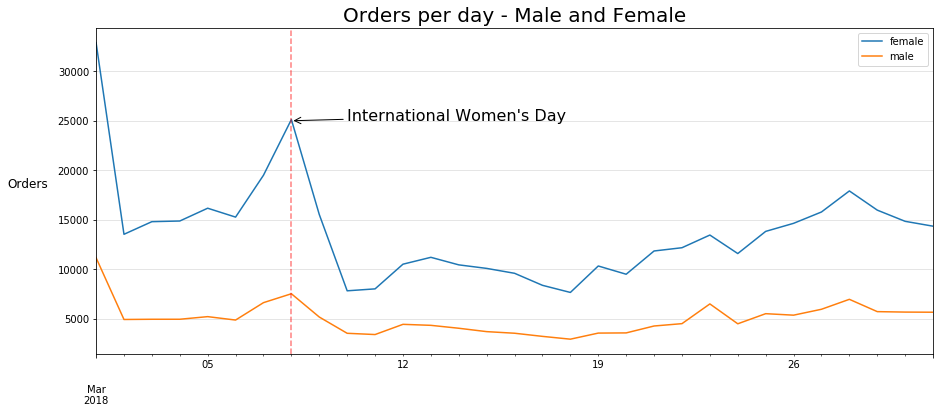

In [104]:
both.plot(figsize = (15,6))

plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)

plt.axvline(datetime.datetime(2018,3,8,0), linestyle='--', color = 'red', alpha = 0.5)

arrow = {'arrowstyle':'->'}

plt.annotate(s = 'International Women\'s Day', 
             xy = (datetime.datetime(2018,3,8,0),25000), 
             xytext = (datetime.datetime(2018,3,10,0),25000), 
             fontsize = 16, 
             arrowprops = arrow)
plt.ylabel('Orders', fontsize = 12, labelpad = 30, rotation = 0)

plt.title('Orders per day - Male and Female', fontsize = 20);

## Are the SKUs gendered?

When the users were segmented by gender, the SKUs that were most commonly purchased
by each gender were examined. If some of the SKUs were bought exclusively by either gender, this
would indicate that the SKUs were gendered. If there were gendered SKUs, this may lead to more
accurate demand forecasts, as the demand would only need to be forecasted for one gender. 

**This was not the case in this product category as almost all products were bought by both genders.**

In [105]:
female_users = users[users.gender == 'F']
orders_females = single_orders[single_orders.user_ID.isin(female_users.user_ID)]
orders_females.sku_ID.value_counts()

068f4481b3    16322
3c79df1d80    10650
623d0a582a     9438
a9109972d1     8924
8dc4a01dec     8828
              ...  
2a65da39e9        1
ed5fc1db7a        1
f4692a1c99        1
eb9da9257c        1
2d92e58c37        1
Name: sku_ID, Length: 7570, dtype: int64

In [106]:
skus_females = set(orders_females.sku_ID)

In [107]:
male_users = users[users.gender == 'M']
orders_males = single_orders[single_orders.user_ID.isin(male_users.user_ID)]
orders_males.sku_ID.value_counts()

a9109972d1    7776
068f4481b3    7144
3c79df1d80    3816
d47c6ca631    3112
623d0a582a    3057
              ... 
634d673e0f       1
d36832332a       1
0c5a8f4f79       1
c8e8270b4f       1
1ae7e81bf6       1
Name: sku_ID, Length: 4962, dtype: int64

In [108]:
skus_males = set(orders_males.sku_ID)

In [109]:
len(skus_males & skus_females) # intersection 

4104

In [110]:
len(skus_males - skus_females) # in males, not in females

858

In [111]:
len(skus_females - skus_males) # in females, not in males

3466

In [112]:
orders_female_no_males = single_orders[single_orders.sku_ID.isin(skus_females - skus_males)]

Observations: 744
Training Observations: 509
Testing Observations: 235


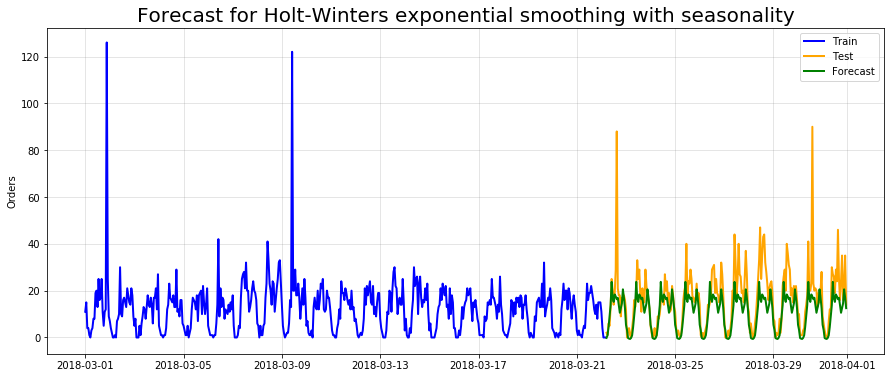

Mean squared error: 109.801
Mean absolute error: 6.350
Mean absolute percentage error: inf
Mean absolute scaled error 1.316


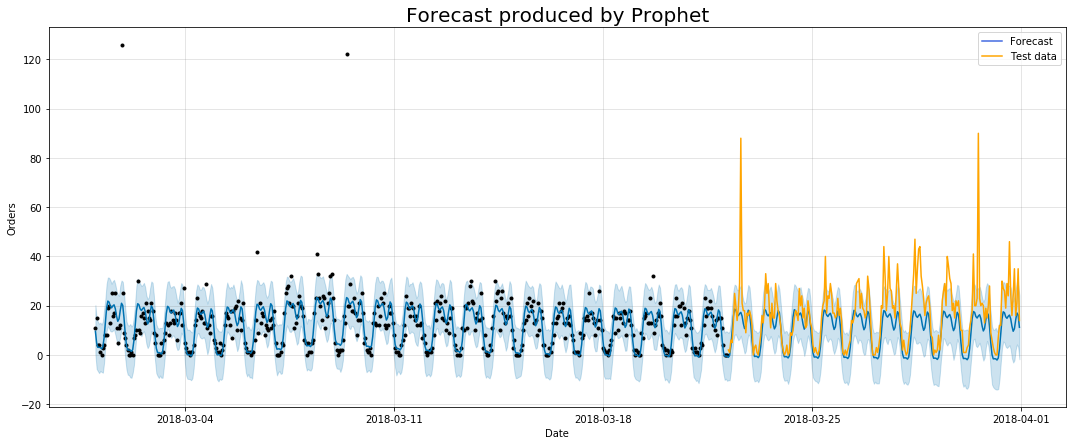

Mean squared error: 122.463
Mean absoloute error: 7.088
Mean absoloute percent error: inf
Mean absolute scaled error 1.469


In [113]:
forecast_all(prepare_for_plotting(orders_female_no_males))

## K-Means clustering on customers

Clustering the customers by the K-Means algorithm and predicting the demand for each
cluster did not lead to more accurate forecasts. This may be due to the different groups having a
similar demand pattern, which is what was found when the customer segmentation was done
manually. It may also be a problem with the clustering algorithm that was chosen. The users had some
features that were categorical, such as gender, and these cannot be modelled with the K-Means
algorithm. Other algorithms such as the K-Medoids algorithm have been proposed to deal with
categorical data. This is listed as a possible avenue for future investigation; however, it was not
pursued due to the manual segmentation of the customers not resulting in any improvements in
forecast accuracy. 

K-Means doesn't work for categorical, so not going to consider categorical attributes of customers. 
Remaining variables:

- user_level - numerical, discrete, ordinal
- age - numerical, discrete, ordinal
- education - numerical, discrete, ordinal
- city_level - numerical, discrete, ordinal
- purchase_power - numerical, discrete, ordinal
- plus - binary

Users with unknown values are dropped (this results in ~150,000 customers being dropped).

Averages of age ranges are used.

In [114]:
num_features_users = users[['user_level', 'plus', 'age', 'education', 'city_level', 'purchase_power']].copy()

In [115]:
def age(row):
    if row['age'] == '26-35':
        row['age'] = 30
    elif row.age == '16-25':
        row.age = 20
    elif row.age == '36-45':
        row.age = 40
    elif row.age == '46-55':
        row.age = 50
    elif row.age == '>=56':
        row.age = 60
    elif row.age == '<=15':
        row.age = 10
    return row

In [116]:
# data prep
num_features_users.purchase_power = [i if i > 0 else np.nan for i in num_features_users.purchase_power]
num_features_users.user_level = [i if i > 0 else np.nan for i in num_features_users.user_level]
num_features_users.user_level = [i if i < 10 else np.nan for i in num_features_users.user_level]
num_features_users.age = [i if i != 'U' else np.nan for i in num_features_users.age]
num_features_users.education = [i if i > 0 else np.nan for i in num_features_users.education]
num_features_users.city_level = [i if i > 0 else np.nan for i in num_features_users.city_level]
num_features_users.dropna(inplace = True)
num_features_users = num_features_users.apply(lambda x: age(x), axis = 1)

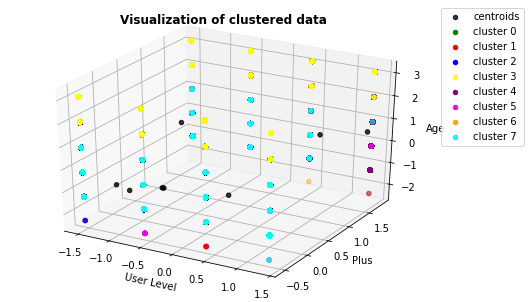

In [117]:
X = np.array(num_features_users)

X_std = StandardScaler().fit_transform(X)

km = KMeans(n_clusters=8, max_iter=100).fit(X_std)

centroids = km.cluster_centers_

# Plot the clustered data
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], color = 'black', label = 'centroids', alpha = 0.8)

# km.labels_ == 0 gives a true false array of which are in cluster 0
# and the ,0 says it's in the first column
ax.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1,], X_std[km.labels_ == 0, 2],
            c='green', label='cluster 0')
ax.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1,], X_std[km.labels_ == 1, 2],
            c='red', label='cluster 1')
ax.scatter(X_std[km.labels_ == 2, 0], X_std[km.labels_ == 2, 1,], X_std[km.labels_ == 2, 2],
            c='blue', label='cluster 2')
ax.scatter(X_std[km.labels_ == 3, 0], X_std[km.labels_ == 3, 1,], X_std[km.labels_ == 3, 2],
            c='yellow', label='cluster 3')
ax.scatter(X_std[km.labels_ == 4, 0], X_std[km.labels_ == 4, 1,], X_std[km.labels_ == 4, 2],
            c='purple', label='cluster 4')
ax.scatter(X_std[km.labels_ == 5, 0], X_std[km.labels_ == 5, 1,], X_std[km.labels_ == 5, 2],
            c='magenta', label='cluster 5')
ax.scatter(X_std[km.labels_ == 6, 0], X_std[km.labels_ == 6, 1,], X_std[km.labels_ == 6, 2],
            c='orange', label='cluster 6')
ax.scatter(X_std[km.labels_ == 7, 0], X_std[km.labels_ == 7, 1,], X_std[km.labels_ == 7, 2],
            c='cyan', label='cluster 7')

plt.legend(loc = 'lower center', bbox_to_anchor=(1.1, 0.5))
ax.set_xlabel('User Level')
ax.set_ylabel('Plus')
ax.set_zlabel('Age')
#ax.set_zlim([-1, 5])
plt.title('Visualization of clustered data', fontweight='bold');

In [118]:
num_features_users['cluster'] = km.labels_

In [119]:
users_ = users.copy()
users_.purchase_power = [i if i > 0 else np.nan for i in users_.purchase_power]
users_.user_level = [i if i > 0 else np.nan for i in users_.user_level]
users_.user_level = [i if i < 10 else np.nan for i in users_.user_level]
users_.age = [i if i != 'U' else np.nan for i in users_.age]
users_.education = [i if i > 0 else np.nan for i in users_.education]
users_.city_level = [i if i > 0 else np.nan for i in users_.city_level]
users_.dropna(inplace = True)
users_ = users_.apply(lambda x: age(x), axis = 1)

In [120]:
# little bit tricky to get the clusters to line up to the correct users because lots of users are dropped before clustering
users_clustered = users_.merge(num_features_users, left_index = True, right_index = True, on = ['user_level', 'plus', 'age', 'education', 'city_level','purchase_power'])

In [121]:
users_clustered.cluster.value_counts()

0    57044
1    51017
7    44929
6    44719
2    39784
5    35586
4    26136
3    17135
Name: cluster, dtype: int64

In [122]:
# here we can use the numbers

cluster0 = users_clustered[users_clustered.cluster == 0]
cluster1 = users_clustered[users_clustered.cluster == 1]
cluster2 = users_clustered[users_clustered.cluster == 2]
cluster3 = users_clustered[users_clustered.cluster == 3]
cluster4 = users_clustered[users_clustered.cluster == 4]
cluster5 = users_clustered[users_clustered.cluster == 5]
cluster6 = users_clustered[users_clustered.cluster == 6]
cluster7 = users_clustered[users_clustered.cluster == 7]

orders_cluster0 = single_orders[single_orders.user_ID.isin(cluster0.user_ID)]
orders_cluster1 = single_orders[single_orders.user_ID.isin(cluster1.user_ID)]
orders_cluster2 = single_orders[single_orders.user_ID.isin(cluster2.user_ID)]
orders_cluster3 = single_orders[single_orders.user_ID.isin(cluster3.user_ID)]
orders_cluster4 = single_orders[single_orders.user_ID.isin(cluster4.user_ID)]
orders_cluster5 = single_orders[single_orders.user_ID.isin(cluster5.user_ID)]
orders_cluster6 = single_orders[single_orders.user_ID.isin(cluster6.user_ID)]
orders_cluster7 = single_orders[single_orders.user_ID.isin(cluster7.user_ID)]

Observations: 744
Training Observations: 509
Testing Observations: 235


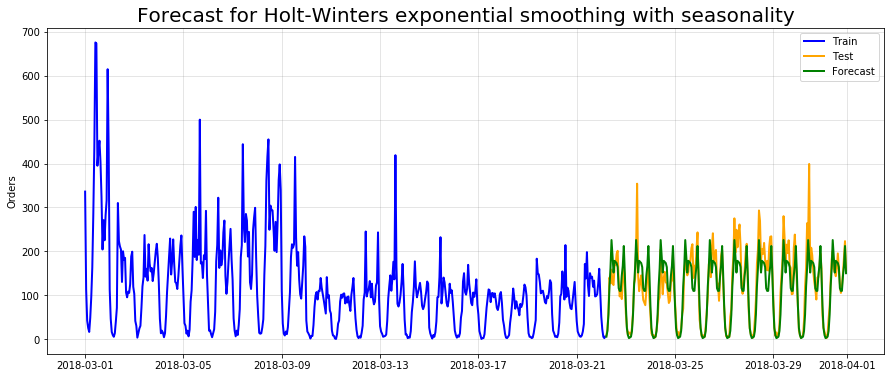

Mean squared error: 1304.446
Mean absolute error: 24.935
Mean absolute percentage error: 25.047
Mean absolute scaled error 0.630


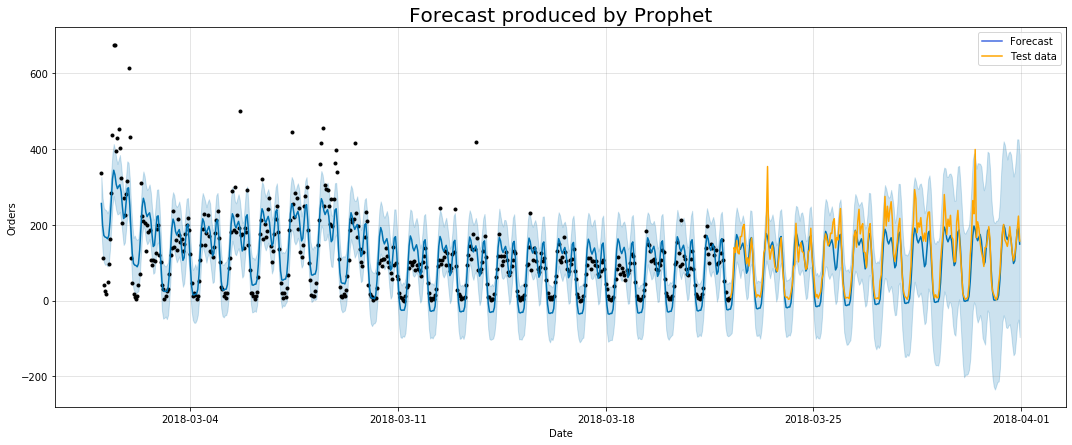

Mean squared error: 1556.031
Mean absoloute error: 28.388
Mean absoloute percent error: 57.985
Mean absolute scaled error 0.717


In [123]:
forecast_all(prepare_for_plotting(orders_cluster0))

Observations: 744
Training Observations: 509
Testing Observations: 235


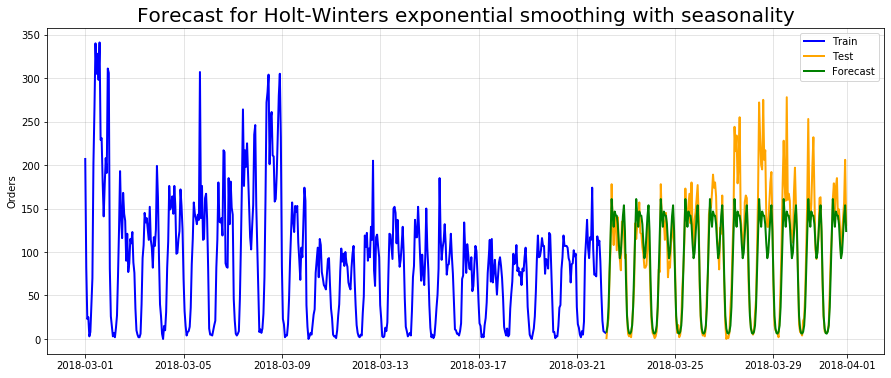

Mean squared error: 955.950
Mean absolute error: 20.328
Mean absolute percentage error: inf
Mean absolute scaled error 0.761


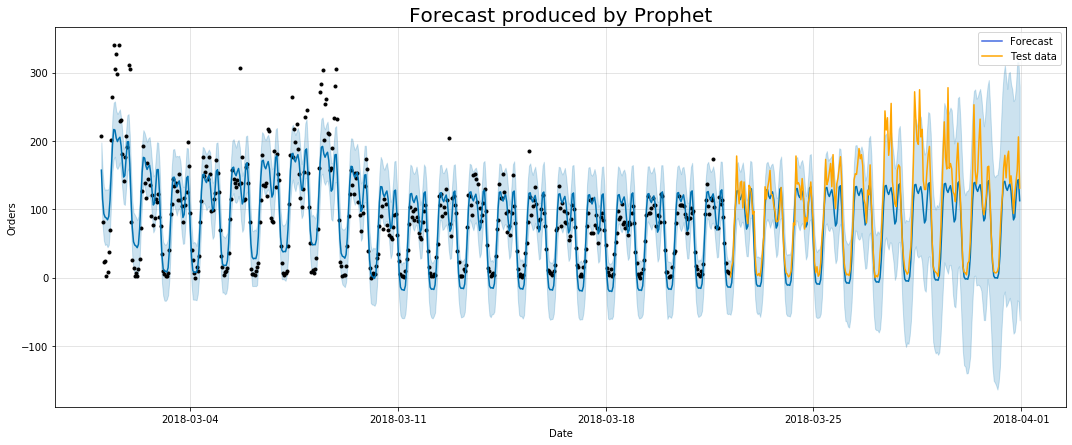

Mean squared error: 1420.220
Mean absoloute error: 26.896
Mean absoloute percent error: inf
Mean absolute scaled error 1.007


In [124]:
forecast_all(prepare_for_plotting(orders_cluster1))

## K-Means with Principal Component Analysis first

**This did not have a significant effect on the accuracy of forecasts.**

In [125]:
X = np.array(num_features_users)
X_std = StandardScaler().fit_transform(X)
X_std

array([[-1.5140583 , -0.55002963, -0.16625338, ...,  1.64569277,
         1.42197538, -0.51906268],
       [ 0.40680996, -0.55002963,  3.10602616, ..., -0.2266826 ,
         1.42197538, -0.12298693],
       [ 0.40680996, -0.55002963, -0.16625338, ..., -0.2266826 ,
        -0.50038488, -1.31121416],
       ...,
       [-0.55362417, -0.55002963, -0.16625338, ...,  0.70950508,
         1.42197538, -0.51906268],
       [ 1.36724409,  1.81808386, -0.16625338, ..., -1.16287028,
        -0.50038488,  1.06524029],
       [ 0.40680996, -0.55002963,  0.92450646, ...,  1.64569277,
        -0.50038488,  1.46131604]])

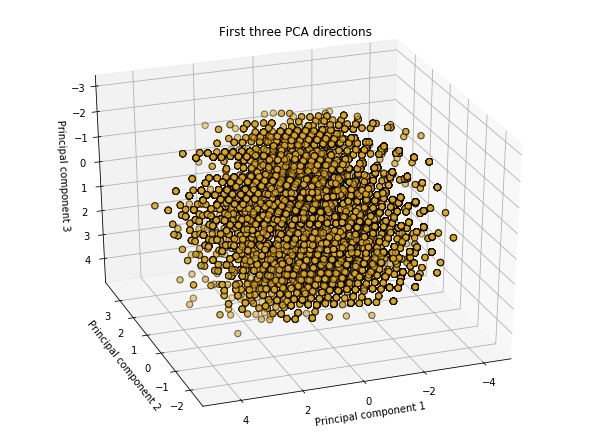

In [126]:
# going to try PCA and then visualise

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_std)

#Visualization
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2],
           c='goldenrod', edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("Principal component 1")
#ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("Principal component 2")
#ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Principal component 3")
#ax.w_zaxis.set_ticklabels([])
plt.show()

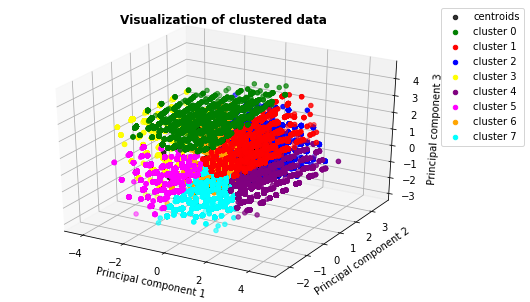

In [127]:
km = KMeans(n_clusters=8, max_iter=100).fit(X_reduced)

centroids = km.cluster_centers_

# Plot the clustered data
fig=plt.figure()
ax=Axes3D(fig)

ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], color = 'black', label = 'centroids', alpha = 0.8)

# km.labels_ == 0 gives a true false array of which are in cluster 0
# and the ,0 says it's in the first column
ax.scatter(X_reduced[km.labels_ == 0, 0], X_reduced[km.labels_ == 0, 1,], X_reduced[km.labels_ == 0, 2],
            c='green', label='cluster 0')
ax.scatter(X_reduced[km.labels_ == 1, 0], X_reduced[km.labels_ == 1, 1,], X_reduced[km.labels_ == 1, 2],
            c='red', label='cluster 1')
ax.scatter(X_reduced[km.labels_ == 2, 0], X_reduced[km.labels_ == 2, 1,], X_reduced[km.labels_ == 2, 2],
            c='blue', label='cluster 2')
ax.scatter(X_reduced[km.labels_ == 3, 0], X_reduced[km.labels_ == 3, 1,], X_reduced[km.labels_ == 3, 2],
            c='yellow', label='cluster 3')
ax.scatter(X_reduced[km.labels_ == 4, 0], X_reduced[km.labels_ == 4, 1,], X_reduced[km.labels_ == 4, 2],
            c='purple', label='cluster 4')
ax.scatter(X_reduced[km.labels_ == 5, 0], X_reduced[km.labels_ == 5, 1,], X_reduced[km.labels_ == 5, 2],
            c='magenta', label='cluster 5')
ax.scatter(X_reduced[km.labels_ == 6, 0], X_reduced[km.labels_ == 6, 1,], X_reduced[km.labels_ == 6, 2],
            c='orange', label='cluster 6')
ax.scatter(X_reduced[km.labels_ == 7, 0], X_reduced[km.labels_ == 7, 1,], X_reduced[km.labels_ == 7, 2],
            c='cyan', label='cluster 7')

plt.legend(loc = 'lower center', bbox_to_anchor=(1.1, 0.5))
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_zlabel('Principal component 3')
#ax.set_zlim([-1, 5])
plt.title('Visualization of clustered data', fontweight='bold');

In [128]:
km.labels_

array([1, 0, 7, ..., 1, 6, 2])

In [129]:
num_features_users['cluster'] = km.labels_
users_clustered = users_.merge(num_features_users, left_index = True, right_index = True, on = ['user_level', 'plus', 'age', 'education', 'city_level','purchase_power'])
users_clustered.cluster.value_counts()

cluster0 = users_clustered[users_clustered.cluster == 0]
cluster1 = users_clustered[users_clustered.cluster == 1]
cluster2 = users_clustered[users_clustered.cluster == 2]
cluster3 = users_clustered[users_clustered.cluster == 3]
cluster4 = users_clustered[users_clustered.cluster == 4]
cluster5 = users_clustered[users_clustered.cluster == 5]
cluster6 = users_clustered[users_clustered.cluster == 6]
cluster7 = users_clustered[users_clustered.cluster == 7]

orders_cluster0 = single_orders[single_orders.user_ID.isin(cluster0.user_ID)]
orders_cluster1 = single_orders[single_orders.user_ID.isin(cluster1.user_ID)]
orders_cluster2 = single_orders[single_orders.user_ID.isin(cluster2.user_ID)]
orders_cluster3 = single_orders[single_orders.user_ID.isin(cluster3.user_ID)]
orders_cluster4 = single_orders[single_orders.user_ID.isin(cluster4.user_ID)]
orders_cluster5 = single_orders[single_orders.user_ID.isin(cluster5.user_ID)]
orders_cluster6 = single_orders[single_orders.user_ID.isin(cluster6.user_ID)]
orders_cluster7 = single_orders[single_orders.user_ID.isin(cluster7.user_ID)]

Observations: 744
Training Observations: 509
Testing Observations: 235


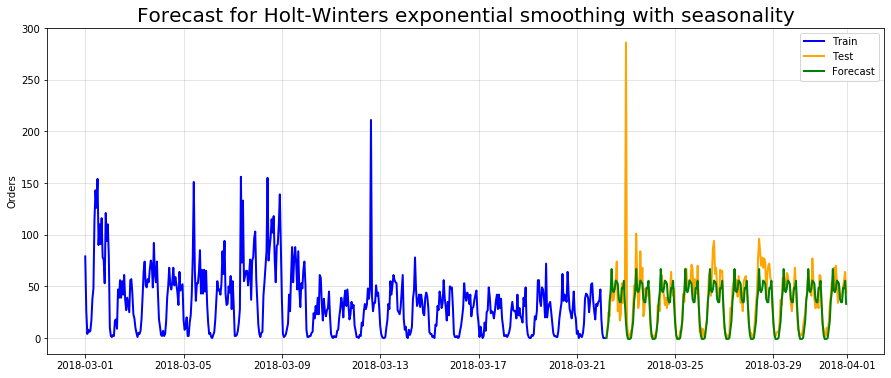

Mean squared error: 466.009
Mean absolute error: 10.241
Mean absolute percentage error: inf
Mean absolute scaled error 0.688


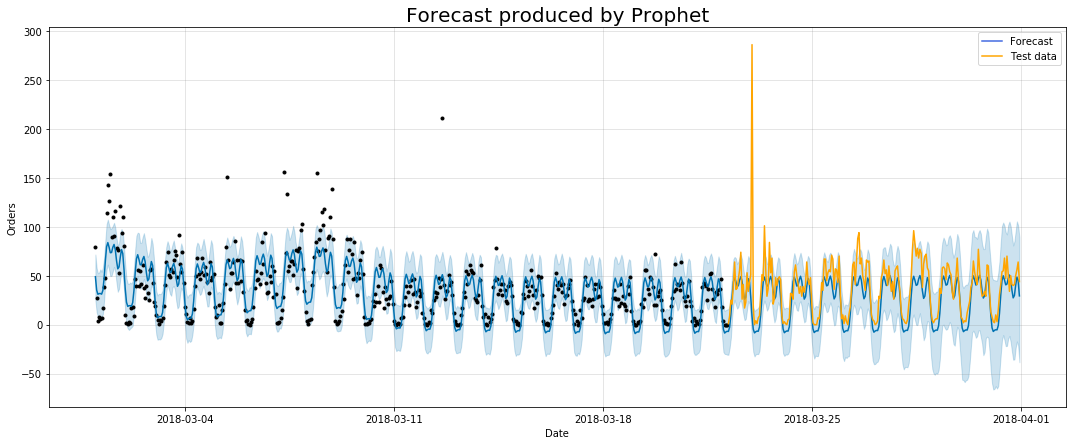

Mean squared error: 577.696
Mean absoloute error: 13.757
Mean absoloute percent error: inf
Mean absolute scaled error 0.925


In [130]:
forecast_all(prepare_for_plotting(orders_cluster0))

Observations: 744
Training Observations: 509
Testing Observations: 235


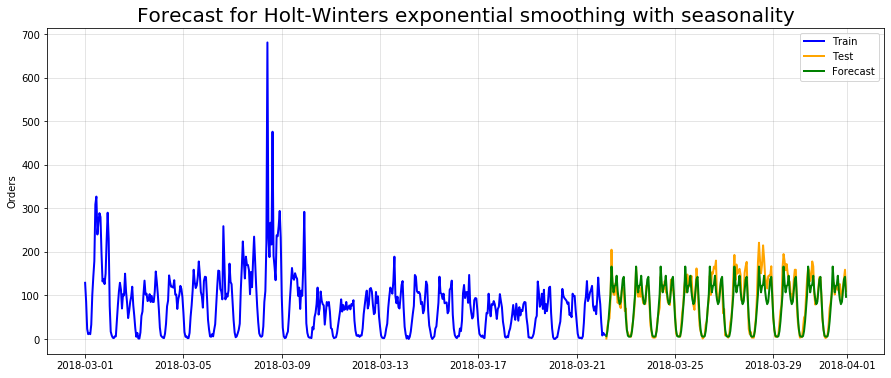

Mean squared error: 522.797
Mean absolute error: 16.438
Mean absolute percentage error: 28.403
Mean absolute scaled error 0.611


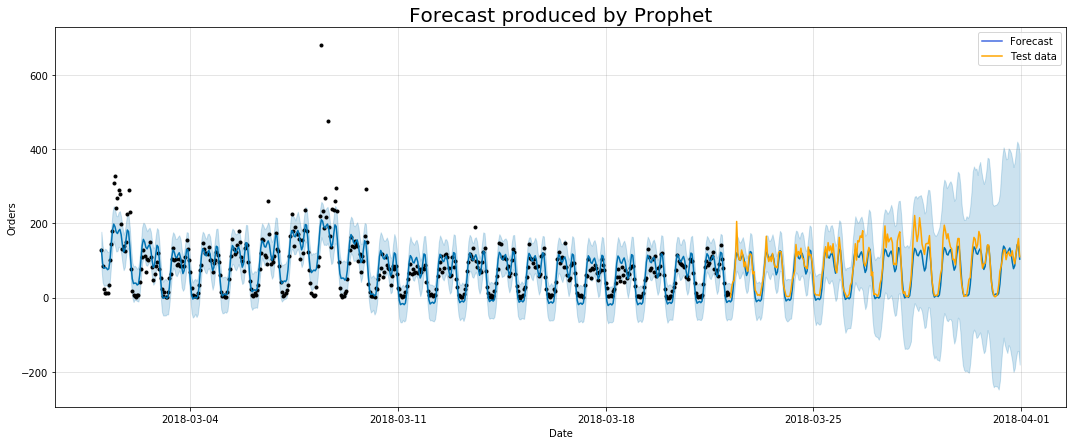

Mean squared error: 663.131
Mean absoloute error: 19.243
Mean absoloute percent error: 47.265
Mean absolute scaled error 0.715


In [131]:
forecast_all(prepare_for_plotting(orders_cluster1))

## Do different clusters buy different products?

It was considered that different clusters might buy different products. This could lead to accurate demand forecasting for a particular product and a particular cluster.

However when the products that were only purchased by one specific cluster were identified, there were not enough of them to produce accurate demand forecasts.

In [132]:
# users that were clustered by PCA
users_clustered

user_ID  user_level first_order_month  plus gender  age  \
0       000089d6a6         1.0           2017-08     0      F   30   
2       0000bc018b         3.0           2016-06     0      F   60   
3       0000d0e5ab         3.0           2014-06     0      M   30   
5       0000f81d1b         1.0           2018-02     0      F   30   
6       00012bb423         4.0           2008-11     1      F   30   
...            ...         ...               ...   ...    ...  ...   
457286  fffedbb471         3.0           2016-10     0      F   50   
457291  ffff0b5ecd         1.0           2017-06     0      F   30   
457292  ffff2284c2         2.0           2015-02     0      F   30   
457294  ffffa1a495         4.0           2011-09     1      M   30   
457295  ffffb20ef7         3.0           2017-11     0      M   40   

       marital_status  education  city_level  purchase_power  cluster  
0                   S        3.0         4.0             3.0        1  
2                   M        3.0         2.0             3.0        0  
3                   M        3.0         2.0             2.0        7  
5                   M        2.0         3.0             2.0        4  
6                   M        4.0         1.0             2.0        3  
...               ...        ...         ...             ...      ...  
457286              M        3.0         1.0             3.0        0  
457291              M        3.0         2.0             3.0        1  
457292              S        3.0         3.0             3.0        1  
457294              S        3.0         1.0             2.0        6  
457295              M        2.0         4.0             2.0        2  

[316350 rows x 11 columns]

In [133]:
set_skus_by_cluster = {
    'skus_cluster0':set(orders_cluster0.sku_ID),
    'skus_cluster1':set(orders_cluster1.sku_ID),
    'skus_cluster2':set(orders_cluster2.sku_ID),
    'skus_cluster3':set(orders_cluster3.sku_ID),
    'skus_cluster4':set(orders_cluster4.sku_ID)}
#     'skus_cluster5':set(orders_cluster5.sku_ID)}
#     'skus_cluster6':set(orders_cluster6.sku_ID),
#     'skus_cluster7':set(orders_cluster7.sku_ID)
# }

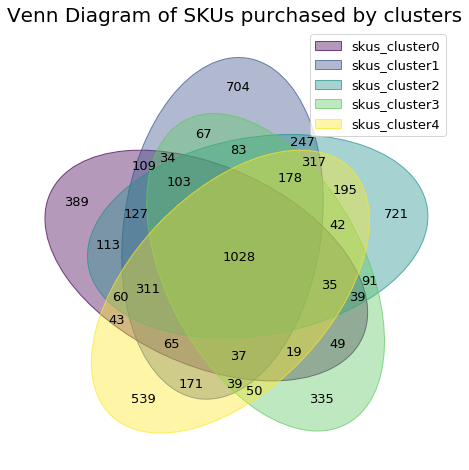

In [134]:
venn(set_skus_by_cluster)
plt.title('Venn Diagram of SKUs purchased by clusters', fontsize = 20);

In [135]:
skus_cluster0 = set(orders_cluster0.sku_ID)
skus_cluster1 = set(orders_cluster1.sku_ID)
skus_cluster2 = set(orders_cluster2.sku_ID)
skus_cluster3 = set(orders_cluster3.sku_ID)
skus_cluster4 = set(orders_cluster4.sku_ID)
skus_cluster5 = set(orders_cluster5.sku_ID)
skus_cluster6 = set(orders_cluster6.sku_ID)
skus_cluster7 = set(orders_cluster7.sku_ID)

skus_only_cluster0 = skus_cluster0 - skus_cluster1 - skus_cluster2 - skus_cluster3 - skus_cluster4 - skus_cluster5 - skus_cluster6 - skus_cluster7
skus_only_cluster1 = skus_cluster1 - skus_cluster0 - skus_cluster2 - skus_cluster3 - skus_cluster4 - skus_cluster5 - skus_cluster6 - skus_cluster7
skus_only_cluster2 = skus_cluster2 - skus_cluster0 - skus_cluster1 - skus_cluster3 - skus_cluster4 - skus_cluster5 - skus_cluster6 - skus_cluster7
skus_only_cluster3 = skus_cluster3 - skus_cluster0 - skus_cluster2 - skus_cluster1 - skus_cluster4 - skus_cluster5 - skus_cluster6 - skus_cluster7
skus_only_cluster4 = skus_cluster4 - skus_cluster0 - skus_cluster2 - skus_cluster3 - skus_cluster1 - skus_cluster5 - skus_cluster6 - skus_cluster7
skus_only_cluster5 = skus_cluster5 - skus_cluster0 - skus_cluster2 - skus_cluster3 - skus_cluster4 - skus_cluster1 - skus_cluster6 - skus_cluster7
skus_only_cluster6 = skus_cluster6 - skus_cluster0 - skus_cluster2 - skus_cluster3 - skus_cluster4 - skus_cluster5 - skus_cluster1 - skus_cluster7
skus_only_cluster7 = skus_cluster7 - skus_cluster0 - skus_cluster2 - skus_cluster3 - skus_cluster4 - skus_cluster5 - skus_cluster6 - skus_cluster1

In [136]:
# not enough SKUs in the clusters to do any real predictions.

print(len(skus_only_cluster0))
print(len(skus_only_cluster1))
print(len(skus_only_cluster2))
print(len(skus_only_cluster3))
print(len(skus_only_cluster4))
print(len(skus_only_cluster5))
print(len(skus_only_cluster6))
print(len(skus_only_cluster7))

252
465
449
212
365
433
243
437


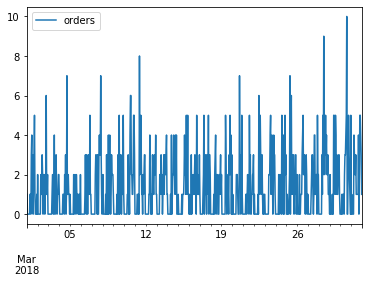

In [137]:
prepare_for_plotting(single_orders[single_orders.sku_ID.isin(skus_only_cluster1)]).plot();

# Experiment 4: Location based aggregation

Demand was examined based on various location based aggregations such as by city level, district, and by region. 

**Aggregating by location did not result in significant increases in forecast accuracy.**

The demand in each region rose on the same days and fell on the same days as you can see in the graph below. There were 454,897 users who purchased items throughout the month of March, across 8 regions. These 8 regions cover almost the entire country of China. The likelihood of the demand pattern being the same across all regions is low. This indicates that in this dataset, location does not have any predictive power over the demand pattern of orders, besides the demand in each region
and district being proportional to the overall demand. It is unlikely that location has almost no
predictive power on demand patterns, what is more likely is that there is another variable that strongly
affects demand, and thus the effect of location cannot be detected. 

**This other variable is believed to be promotions and discounts and is examined in the next section.**

In [138]:
network = pd.read_csv('../Data/JD_network_data.csv')

In [139]:
def prepare_for_plotting_(df):
    df = pd.DataFrame(df['order_date'])

    # change the string values to datetime and set it as the index
    df['order_date'] = pd.to_datetime(df['order_date'])
    df.set_index('order_date', inplace=True)

    # value counts gets all of the orders that happened that hour
    df = df.index.value_counts().sort_index()

    df = pd.DataFrame(df)
    df.rename(columns = {0:'orders'}, inplace = True)
    return df

In [140]:
def district_to_region(x):
    try:
        return dc_to_region[x]
    
    # some districts aren't listed in the network df, so just going to dropna()
    except KeyError:
        return np.nan

In [141]:
# maps each district to its region
dc_to_region = dict(zip(network.dc_ID, network.region_ID))

In [142]:
# make data frame that has region as well as district in it
orders_des = single_orders.copy()
orders_des['region_des'] = orders_des.dc_des.apply(lambda x : district_to_region(x))
orders_des.dropna(inplace = True)

In [143]:
# dataframe with demand in each region as a column

regions_corr = []
series = orders_des['region_des'].value_counts()
for index in series.index:
    single_orders_ = orders_des[orders_des.region_des == index]
    regions_corr.append(prepare_for_plotting_(single_orders_))
    
regions_corr = pd.concat(regions_corr, axis = 1)
regions_corr.columns = ['region {}'.format(str(x)) for x in series.index]

In [144]:
# the demand in all of the regions is highly correlated
regions_corr.corr()

region 9.0  region 2.0  region 5.0  region 4.0  region 7.0  \
region 9.0     1.000000    0.790570    0.806004    0.870017    0.698837   
region 2.0     0.790570    1.000000    0.888938    0.720968    0.947171   
region 5.0     0.806004    0.888938    1.000000    0.767815    0.874903   
region 4.0     0.870017    0.720968    0.767815    1.000000    0.659223   
region 7.0     0.698837    0.947171    0.874903    0.659223    1.000000   
region 24.0    0.569953    0.845586    0.762857    0.562100    0.889027   
region 3.0     0.552096    0.870127    0.861595    0.494821    0.895215   
region 10.0    0.824960    0.903370    0.968294    0.796033    0.859326   

             region 24.0  region 3.0  region 10.0  
region 9.0      0.569953    0.552096     0.824960  
region 2.0      0.845586    0.870127     0.903370  
region 5.0      0.762857    0.861595     0.968294  
region 4.0      0.562100    0.494821     0.796033  
region 7.0      0.889027    0.895215     0.859326  
region 24.0     1.000000    0.871931     0.759351  
region 3.0      0.871931    1.000000     0.861789  
region 10.0     0.759351    0.861789     1.000000

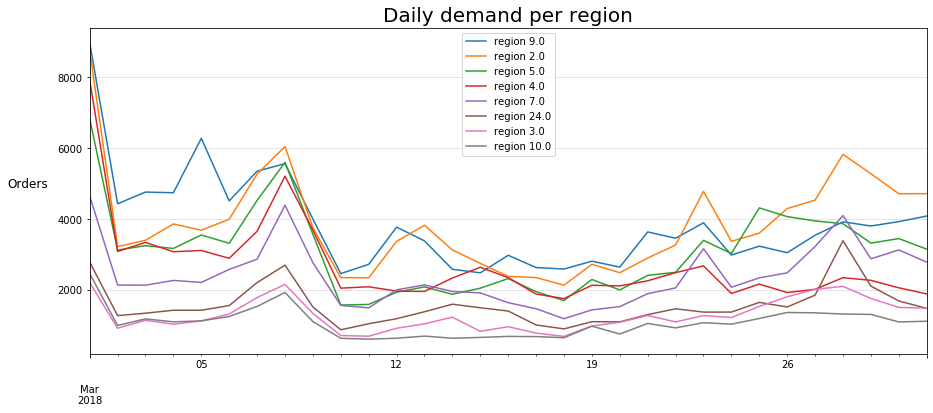

In [145]:
regions_corr.plot(figsize = (15,6))
plt.title('Daily demand per region', fontsize = 20)
plt.grid(b=True, which = 'major', axis = 'both', color = 'grey', alpha = 0.25)
plt.ylabel('Orders', fontsize = 12, rotation = 0, labelpad = 30);

# Experiment 5: Discounts

## Exploring discounts

There are four common types of promotional discounts on the JD.com platform: (1) SKU direct discount, (2) group promotion, (3) bundle promotion, and (4) gift items. These four types of discounts can be described asfollows:

- (1) The seller of an SKU may offer a price cut in terms of a **direct discount**. This discount reflects the reduction in the list price as stated on the product detail page.
- (2) The seller of an SKU may offer a **quantity discount** to entice the customer to buy more. This quantity discount promotion can take different forms including “get an RMB 100 discount if buying over RMB 199” or “buy 3 and get 1 free.” We note that the quantity discount promotion is usually on the order level and we apply a simple allocation rule to calculate the contribution provided by each SKU in the order.
- (3) The seller may offer a **bundle_discount** if a customer buys a “pre-specified bundle” of SKUs within an order.
- (4) The seller may offer an SKU as a **“free gift”** (gift_item value = 1) if the customer purchases a “pre-specified set” of SKUs (e.g., get a free eraser if you buy x pencils and y pads of paper). The final_unit_price for each gift item is always equal to 0.

**Coupons** can also be applied to the order after all other promotions are applied. In contrast to the four aforementioned promotion activities where discounts will be applied automatically once certain criteria are met, customers need to “clip” (or claim) a coupon before making a purchase. The field coupon_discount records the coupon promotional value associated with an order. Similar to quantity discount as explained earlier, the discount value of the coupon is allocated between items in the same order using an allocation rule when necessary.

In [146]:
orders[['direct_discount_per_unit', 'quantity_discount_per_unit', 'bundle_discount_per_unit', 'coupon_discount_per_unit']].describe()

direct_discount_per_unit  quantity_discount_per_unit  \
count             549989.000000               549989.000000   
mean                  19.845889                    7.843390   
std                   33.593536                   17.994354   
min                    0.000000                    0.000000   
25%                    0.000000                    0.000000   
50%                    4.000000                    0.000000   
75%                   21.000000                    0.000000   
max                  720.000000                  225.000000   

       bundle_discount_per_unit  coupon_discount_per_unit  
count             549989.000000             549989.000000  
mean                   0.625649                  2.926015  
std                    6.442281                 11.588338  
min                    0.000000                  0.000000  
25%                    0.000000                  0.000000  
50%                    0.000000                  0.000000  
75%                    0.000000                  0.000000  
max                  252.000000                210.000000

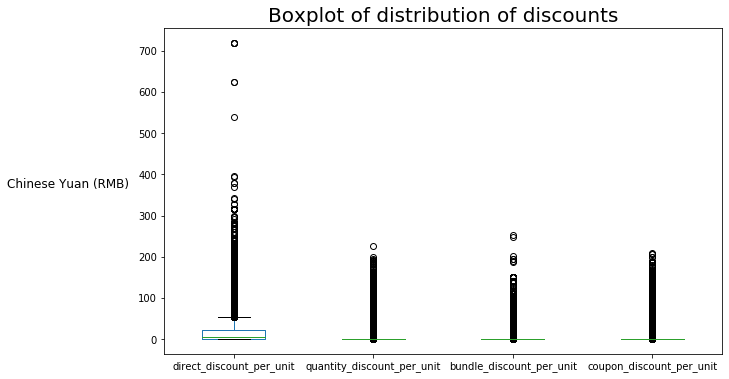

In [147]:
orders[['direct_discount_per_unit', 'quantity_discount_per_unit', 'bundle_discount_per_unit', 'coupon_discount_per_unit']].plot(kind='box', figsize = (10,6))
plt.ylabel('Chinese Yuan (RMB)', fontsize = 12, rotation = 0, labelpad = 70)
plt.title('Boxplot of distribution of discounts', fontsize = 20);

## Discounts and Thursdays

The pattern that presented itself throughout this study was almost a weekly pattern, with orders peaking around the Thursday. However, the pattern did not occur every week, there were only very weak spikes to be seen on Thursday the 15th and the 22nd of March. Initially it was believed that because JD.com deliver most of their packages within one or two days, customers were purchasing items for the weekend on Thursdays and this led to an increase in sales. However, this does not explain the dips on the 15th and the 22nd of March. It was hypothesised that promotions and discounts were the reasons for the distinct pattern that emerged throughout the dataset.

**It was investigated if more discounts were being offered on Thursdays. A one tailed two sample t-test was conducted to determine if the mean discount being offered on Thursdays was different to the mean discount being offered on other days of the week. It was established that there was a significant difference between the discounts on Thursdays and the discounts on other days of the week. The discounts on Thursdays were larger, on average, than on other days of the week.**

In [148]:
thursdays = ['2018-03-01', '2018-03-08', '2018-03-15','2018-03-22','2018-03-29']

### Direct Discounts

In [149]:
# direct discounts orders not on Thursdays
orders[~orders.order_date.isin(thursdays)].direct_discount_per_unit.describe()

count    434158.000000
mean         19.821940
std          33.775554
min           0.000000
25%           0.000000
50%           4.000000
75%          21.000000
max         720.000000
Name: direct_discount_per_unit, dtype: float64

In [150]:
# direct discounts on thursdays
orders[orders.order_date.isin(thursdays)].direct_discount_per_unit.describe()

count    115831.000000
mean         19.935656
std          32.902322
min           0.000000
25%           0.000000
50%           4.000000
75%          21.000000
max         720.000000
Name: direct_discount_per_unit, dtype: float64

In [151]:
# test between not thursdays and thursdays - direct discount
stats.ttest_ind(orders[~orders.order_date.isin(thursdays)].direct_discount_per_unit, orders[orders.order_date.isin(thursdays)].direct_discount_per_unit, equal_var = False)

Ttest_indResult(statistic=-1.0392155075134129, pvalue=0.29870586936447097)

### Quantity Discounts

In [152]:
# quantity discounts not thursdays
orders[~orders.order_date.isin(thursdays)].quantity_discount_per_unit.describe()

count    434158.000000
mean          7.060291
std          16.934721
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         225.000000
Name: quantity_discount_per_unit, dtype: float64

In [153]:
# quantity discounts on thursdays
orders[orders.order_date.isin(thursdays)].quantity_discount_per_unit.describe()

count    115831.000000
mean         10.778601
std          21.251230
min           0.000000
25%           0.000000
50%           0.000000
75%          12.200000
max         191.000000
Name: quantity_discount_per_unit, dtype: float64

In [154]:
# test between not thursdays and thursdays - quantity discount
stats.ttest_ind(orders[~orders.order_date.isin(thursdays)].quantity_discount_per_unit, orders[orders.order_date.isin(thursdays)].quantity_discount_per_unit, equal_var = False)

Ttest_indResult(statistic=-55.06665437528425, pvalue=0.0)

### Bundle discounts

In [155]:
# bundle discount per unit not thursdays
orders[~orders.order_date.isin(thursdays)].bundle_discount_per_unit.describe()

count    434158.000000
mean          0.569803
std           6.032351
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         252.000000
Name: bundle_discount_per_unit, dtype: float64

In [156]:
# bundle discount per unit thursdays
orders[orders.order_date.isin(thursdays)].bundle_discount_per_unit.describe()

count    115831.000000
mean          0.834970
std           7.785581
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         201.000000
Name: bundle_discount_per_unit, dtype: float64

In [157]:
# test between not thursdays and thursdays - bundle discount
stats.ttest_ind(orders[~orders.order_date.isin(thursdays)].bundle_discount_per_unit, orders[orders.order_date.isin(thursdays)].bundle_discount_per_unit, equal_var = False)

Ttest_indResult(statistic=-10.7616900475281, pvalue=5.336597933887692e-27)

### Coupon discounts

In [158]:
# coupon discount per unit not thursdays
orders[~orders.order_date.isin(thursdays)].coupon_discount_per_unit.describe()

count    434158.000000
mean          2.551261
std          10.852537
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         210.000000
Name: coupon_discount_per_unit, dtype: float64

In [159]:
# coupon discount per order thursdays
orders[orders.order_date.isin(thursdays)].coupon_discount_per_unit.describe()

count    115831.000000
mean          4.330668
std          13.916969
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         206.000000
Name: coupon_discount_per_unit, dtype: float64

In [160]:
# test between not thursdays and thursdays - coupon discount
stats.ttest_ind(orders[~orders.order_date.isin(thursdays)].coupon_discount_per_unit, orders[orders.order_date.isin(thursdays)].coupon_discount_per_unit, equal_var = False)

Ttest_indResult(statistic=-40.3641336619084, pvalue=0.0)

## Peak Thursdays

**To determine why there were no peaks on certain Thursdays, four more t-tests were conducted. The
differences between the mean discounts on the ‘not peak Thursdays’ (the 15th and 22nd of March) and
on other days of the week. It was established that there were higher quantity, coupon, and direct
discounts offered on ‘not peak Thursdays’; however, there was no significant difference between the
bundle discounts offered. This means that low bundle discounts coincide with a low number of orders**

In [161]:
not_peak_thursdays = ['2018-03-15','2018-03-22']

In [162]:
# test between not thursdays and not peak thursdays - coupon discount
# expect no difference because no peaks on these thursdays
stats.ttest_ind(orders[~orders.order_date.isin(thursdays)].coupon_discount_per_unit, orders[orders.order_date.isin(not_peak_thursdays)].coupon_discount_per_unit, equal_var = False)

Ttest_indResult(statistic=5.402946218653001, pvalue=6.600099607797386e-08)

In [163]:
# test between not thursdays and not peak thursdays - qunatity discount
# expect no difference because no peaks on these thursdays
stats.ttest_ind(orders[~orders.order_date.isin(thursdays)].quantity_discount_per_unit, orders[orders.order_date.isin(not_peak_thursdays)].quantity_discount_per_unit, equal_var = False)

Ttest_indResult(statistic=26.076655952570356, pvalue=1.6024175823581707e-148)

In [164]:
# test between not thursdays and not peak thursdays - bundle discount
# expect no difference because no peaks on these thursdays
stats.ttest_ind(orders[~orders.order_date.isin(thursdays)].bundle_discount_per_unit, orders[orders.order_date.isin(not_peak_thursdays)].bundle_discount_per_unit, equal_var = False)

Ttest_indResult(statistic=0.5822366523504291, pvalue=0.5604112454001375)

In [165]:
# test between not thursdays and not peak thursdays - direct discount
# expect no difference because no peaks on these thursdays
stats.ttest_ind(orders[~orders.order_date.isin(thursdays)].direct_discount_per_unit, orders[orders.order_date.isin(not_peak_thursdays)].direct_discount_per_unit, equal_var = False)

Ttest_indResult(statistic=7.03487832349203, pvalue=2.0327403176278706e-12)

## Correlation between discounts and orders

To examine the relationship between the discounts and the orders further the correlation between
the orders per day and the mean discount per day was examined. It was established that there was a
positive correlation between the number of orders and the mean discount that was available. The
discount with the highest correlation to the number of orders per day was the bundle discount, which
matches the results of the second round of t-tests, that lower bundle discounts coincide with lower
orders.

It is difficult to determine the direction of causation in this case. It is possible that a
confounding variable caused demand to increase on the 1st, 8th and 29th of March, and this led to a
corresponding increase in the average discounts on orders. However, it is more likely that there were
discounts being offered on these days and they resulted in a higher customer demand. It is
recommended that experiments be ran to test this hypothesis. The variable that caused the increase
in customer demand on the 1st, 8th and 29th of March, whether it be a confounding variable or the
discounts offered, is the most powerful predictor of customer demand that was found, and could be
used to build a highly accurate econometric forecast model, or a time-series model with exogenous
variables. 

In [166]:
days_march = [datetime.datetime(2018, 3, day).strftime('%Y-%m-%d') for day in range(1, 32)]

In [167]:
mean_direct_discount = []
mean_quantity_discount = []
mean_bundle_discount = []
mean_coupon_discount = []
orders_day = []
for date in days_march:
    mean_direct_discount.append(orders[orders.order_date == date].direct_discount_per_unit.mean())
    mean_quantity_discount.append(orders[orders.order_date == date].quantity_discount_per_unit.mean())
    mean_bundle_discount.append(orders[orders.order_date == date].bundle_discount_per_unit.mean())
    mean_coupon_discount.append(orders[orders.order_date == date].coupon_discount_per_unit.mean())
    orders_day.append(len(single_orders[single_orders.order_date == date]))

In [168]:
discount_vs_orders = pd.DataFrame(index = days_march, data = {'mean_bundle_discount':mean_bundle_discount, 
                                         'mean_coupon_discount':mean_coupon_discount, 
                                         'mean_direct_discount':mean_direct_discount, 
                                         'mean_quantity_discount':mean_quantity_discount, 
                                         'orders_day':orders_day})
discount_vs_orders.index = pd.to_datetime(discount_vs_orders.index)

In [169]:
discount_vs_orders.corr()

mean_bundle_discount  mean_coupon_discount  \
mean_bundle_discount                1.000000              0.429628   
mean_coupon_discount                0.429628              1.000000   
mean_direct_discount                0.270074              0.010565   
mean_quantity_discount              0.542633              0.098585   
orders_day                          0.801917              0.513098   

                        mean_direct_discount  mean_quantity_discount  \
mean_bundle_discount                0.270074                0.542633   
mean_coupon_discount                0.010565                0.098585   
mean_direct_discount                1.000000                0.034345   
mean_quantity_discount              0.034345                1.000000   
orders_day                          0.234219                0.697435   

                        orders_day  
mean_bundle_discount      0.801917  
mean_coupon_discount      0.513098  
mean_direct_discount      0.234219  
mean_quantity_discount    0.697435  
orders_day                1.000000

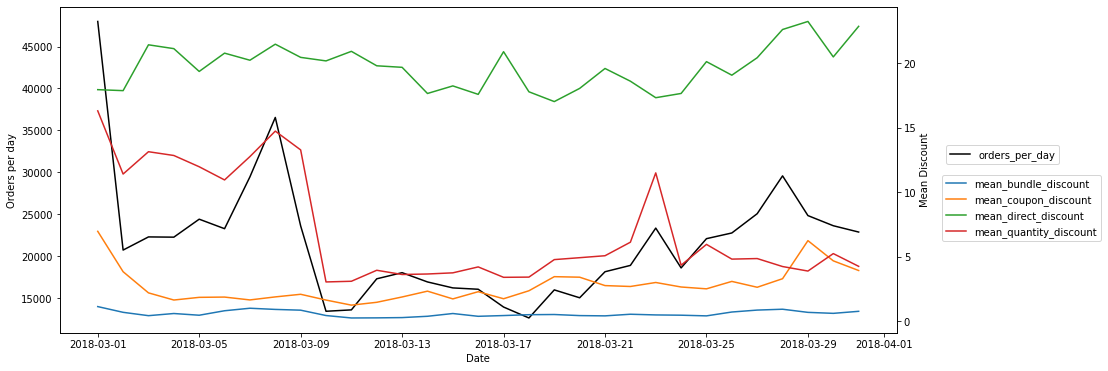

In [170]:
fig, ax1 = plt.subplots(figsize = (15,6))

ax1.set_xlabel('Date')
ax1.set_ylabel('Orders per day')
ax1.plot(discount_vs_orders.orders_day, label = 'Orders Per Day', color = 'black')

plt.legend(labels=['orders_per_day'], bbox_to_anchor=(1.2, 0.59))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

labels = ['mean_bundle_discount', 'mean_coupon_discount', 'mean_direct_discount',
       'mean_quantity_discount']

ax2.set_ylabel('Mean Discount')  # we already handled the x-label with ax1
ax2.plot(discount_vs_orders[['mean_bundle_discount', 'mean_coupon_discount', 'mean_direct_discount',
       'mean_quantity_discount']])

# ax2.set_ylabel('Mean Discount')  # we already handled the x-label with ax1
# ax2.plot(discount_vs_orders[['mean_bundle_discount']])

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(labels=labels, bbox_to_anchor=(1.25, 0.5))
plt.show()

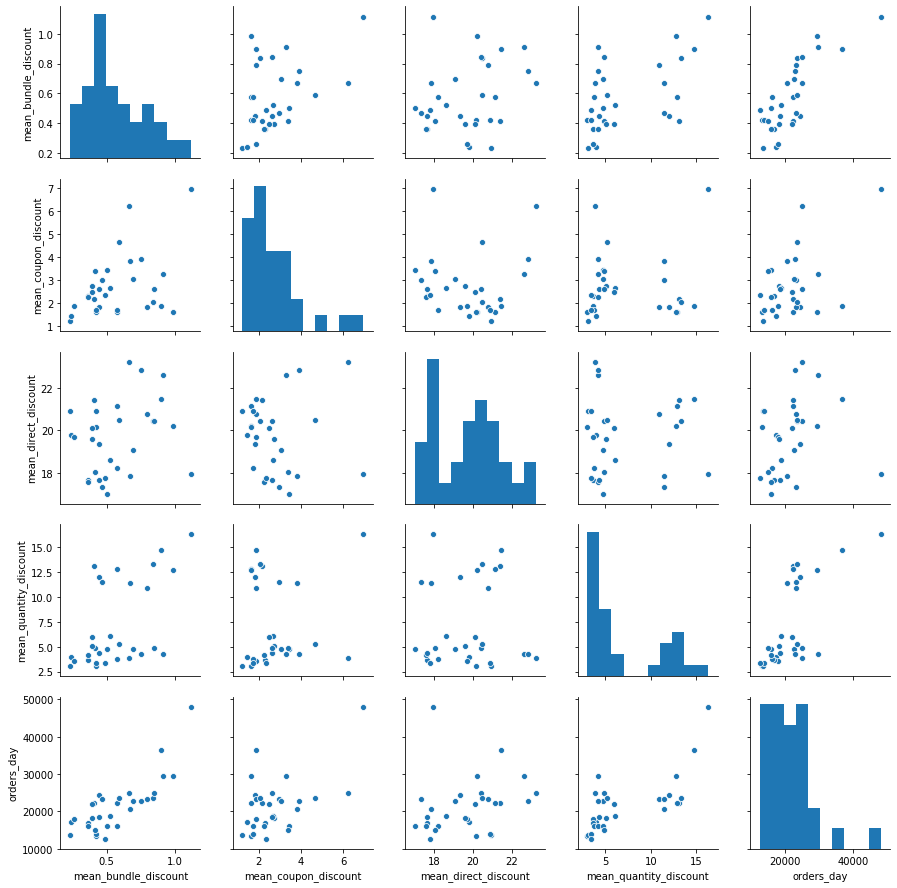

In [171]:
sns.pairplot(discount_vs_orders)